In [ ]:
# create/activate venv (ypd_venv)

# create
# python -m venv ypd_venv
# 
# activate
# ypd_venv\Scripts\activate


Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 3.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 2.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 1.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Path

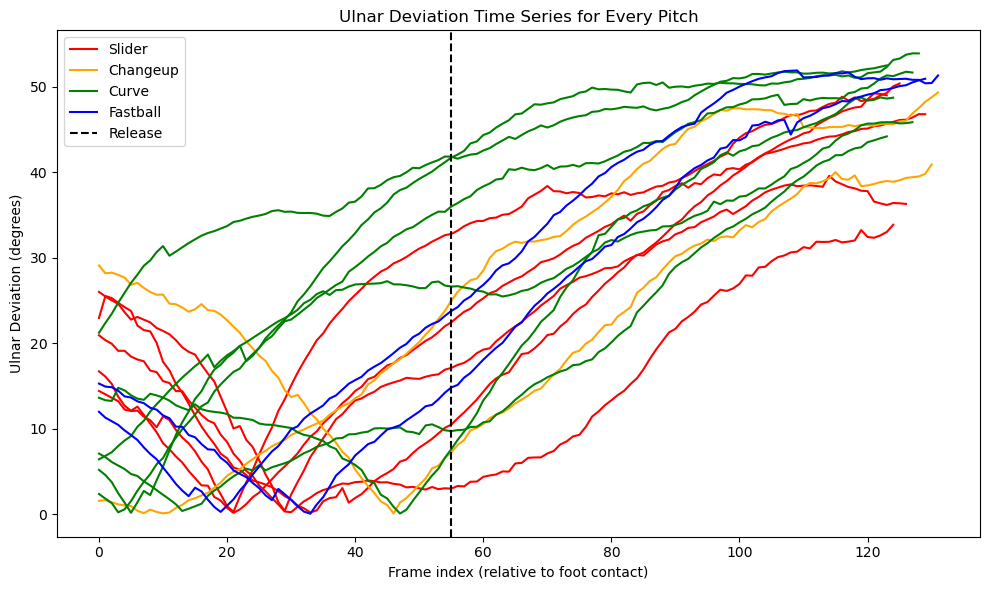

In [11]:
# does everything perfect up to the dash board area

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import dash
from dash import dcc, html, dash_table
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically, selected_folder = "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"
#   so that the .c3d files within that folder are processed.

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_ulnar_deviation(points, marker_indices, frame):
    # Markers
    R = points[:3, marker_indices["Wrist_Radius"], frame]  # radius styloid
    U = points[:3, marker_indices["Wrist_Ulna"], frame]    # ulna styloid
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Midpoints
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Vectors
    forearm_vec = E_center - W_center
    radial_vec  = R - U
    hand_vec    = H - W_center

    # Normalize the forearm axis
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Project vectors onto plane orthogonal to the forearm axis
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit)*forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit)*forearm_unit

    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0

    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj   / np.linalg.norm(hand_proj)

    cross_val = np.cross(radial_proj_n, hand_proj_n)
    dot_val   = np.dot(radial_proj_n, hand_proj_n)
    # Use arctan2 for a robust angle measurement
    angle_rad = np.arctan2(np.linalg.norm(cross_val), dot_val)
    sign = np.sign(np.dot(cross_val, forearm_unit))
    angle_deg = np.degrees(angle_rad) * sign

    # Adjust the computed angle to reflect deviation from a neutral (nearly 180°) position.
    # For example, if a neutral configuration yields an angle of about 180°, then:
    angle_deg_corrected = 180 - abs(angle_deg)
    
    return angle_deg_corrected




def compute_pronation(points, marker_indices, frame):
    """
    Returns approximate pronation/supination angle in degrees.
    Positive => pronation, Negative => supination.
    """
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Vector from wrist_ulna to wrist_radius
    # or from center to radius, etc. 
    # We'll measure the angle around the forearm axis
    # for the "radius-ulna" line. 
    wrist_vec = R - U

    # Project wrist_vec onto plane orthonormal to forearm
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    # For reference, let's define a "neutral" vector. For simplicity,
    # we can define "neutral" as pointing straight up in the plane, or
    # define it from a known "zero" frame. But let's do a small hack:
    # We'll define the medial-lateral direction of the elbow as a reference.
    # It's an approximation.
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0  # Can't define angle

    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)

    cross_val  = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val    = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_wrist_flexion(points, marker_indices, frame):
    """
    Computes an adjusted wrist flexion angle in degrees.
    We define a neutral flexion reference by projecting a global vertical vector 
    (assumed to be [0,0,1] if Z is up) into the plane orthogonal to the forearm.
    The flexion angle is then defined as 180 - |raw_angle| so that if the computed
    raw angle is near 180° (neutral), the flexion deviation is near 0°.
    """
    # Marker positions
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Compute centers
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Compute forearm vector (from elbow center to wrist center)
    forearm_vec = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Define a global vertical vector (assuming Z-up)
    vertical = np.array([0, 0, 1])
    # Project vertical into the plane orthogonal to the forearm to get a neutral reference
    neutral = vertical - np.dot(vertical, forearm_unit) * forearm_unit
    if np.linalg.norm(neutral) < 1e-9:
        return 0.0
    neutral_n = neutral / np.linalg.norm(neutral)

    # Define the hand vector (from wrist center to hand) and project it into the same plane
    hand_vec = H - W_center
    hand_proj = hand_vec - np.dot(hand_vec, forearm_unit) * forearm_unit
    if np.linalg.norm(hand_proj) < 1e-9:
        return 0.0
    hand_proj_n = hand_proj / np.linalg.norm(hand_proj)

    # Compute the raw angle between the neutral reference and the hand orientation
    dot_val = np.dot(neutral_n, hand_proj_n)
    # Clip the dot value to prevent numerical errors
    dot_val = np.clip(dot_val, -1.0, 1.0)
    angle_rad = np.arccos(dot_val)
    cross_val = np.cross(neutral_n, hand_proj_n)
    sign = np.sign(np.dot(cross_val, forearm_unit))
    raw_angle = np.degrees(angle_rad) * sign

    # Correct the angle so that a neutral (raw angle near 180°) gives near 0° flexion.
    flexion_angle = 180 - abs(raw_angle)
    return flexion_angle


def find_local_events(c3d, frame_rate, total_frames):
    """Given the presence of 'Foot Contact' and 'Release' events, find frames."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]  # row=1 => actual times

    # We'll handle both events below. You may adjust naming as needed:
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]

    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest

    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_local, release_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """Return arrays for (forearm) and (hand) segments so they can be plotted in Dash."""
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments

# Dictionary for storing pitch data for Dash
all_pitches = {}

# Create one single table if you prefer, or create multiple. This example creates one table "pitch_data".
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_file_path in c3d_files:
    # Normalize the path to ensure correct separators
    normalized_path = os.path.normpath(c3d_file_path)
    path_parts = normalized_path.split(os.sep)
    print("Path parts:", path_parts)  # Debug: see the parts of the path

    # Ensure there are at least 3 parts (participant, date, filename)
    if len(path_parts) < 3:
        print("Unexpected file path format:", c3d_file_path)
        continue

    # (a) Participant name from the third-to-last folder:
    participant_folder = path_parts[-3]  # e.g., "Bobby Wahl_BW"
    participant_name = participant_folder.rsplit("_", 1)[0]  # "Bobby Wahl"

    # (b) Date folder from the second-to-last folder:
    date_folder = path_parts[-2]  # e.g., "2025-02-05_"
    pitch_date = date_folder.rstrip("_")  # "2025-02-05"

    # (c) Pitch type from the filename:
    filename_only = path_parts[-1]  # e.g., "Slider RH 3.c3d"
    filename_noext = os.path.splitext(filename_only)[0]  # e.g., "Slider RH 3"
    pitch_type = filename_noext.split()[0].capitalize()  # e.g., "Slider"

    # (d) Full file path remains unchanged:
    full_file_path = c3d_file_path

    print("Participant:", participant_name)
    print("Pitch Date:", pitch_date)
    print("Pitch Type:", pitch_type)
    print("Full File Path:", full_file_path)


    # ----------------------------------------------------------
    # 2) Read the C3D
    # ----------------------------------------------------------
    print(f"Processing: {c3d_file_path}")
    c3d = ezc3d.c3d(c3d_file_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Low-pass filter the data before computing angles:
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = lowpass_filter(points[:3, i, :], cutoff=10, fs=frame_rate)

    # (d) Find events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # (e) Make sure we have frames after release
    if release_frame + 20 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
        continue

    # Region of interest
    start_frame = foot_contact_frame
    end_frame = release_frame + 70  # Switch to total_frames if I want to switch to whole trial
    release_index = release_frame - foot_contact_frame

    # (f) Confirm needed markers exist
    # You can rename these if the actual marker labels differ
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    marker_labels = clean_labels

    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker '{mk}' not found.")
            marker_indices = None
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not marker_indices:
        continue

    # ----------------------------------------------------------
    # 3) Compute angles or positions you need
    # ----------------------------------------------------------
    # Instead of using compute_wrist_flexion_pronation, compute the flexion and pronation angles individually.
    flexion_angles = []
    pronation_angles = []
    for frame in range(start_frame, end_frame):
        f_angle = compute_wrist_flexion(points, marker_indices, frame)
        p_angle = compute_pronation(points, marker_indices, frame)
        flexion_angles.append(f_angle)
        pronation_angles.append(p_angle)


    # For the 3D segments we want to animate in Dash:
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=start_frame, end_frame=end_frame
    )
        
    # Compute ulnar deviation time series from midway to release+20 frames
    ulnar_dev_series = []
    for frame in range(start_frame, end_frame):
        ulnar_dev_series.append(compute_ulnar_deviation(points, marker_indices, frame))
    
    # Update or initialize the in-memory dictionary for this pitch type
    if pitch_type not in all_pitches:
        all_pitches[pitch_type] = {
            "ulnar_dev_series": [ulnar_dev_series],
            "forearm": [forearm_segments],
            "hand": [hand_segments],
            "flexion": [flexion_angles],
            "pronation": [pronation_angles]
        }
    else:
        all_pitches[pitch_type]["ulnar_dev_series"].append(ulnar_dev_series)
        all_pitches[pitch_type]["forearm"].append(forearm_segments)
        all_pitches[pitch_type]["hand"].append(hand_segments)
        all_pitches[pitch_type]["flexion"].append(flexion_angles)
        all_pitches[pitch_type]["pronation"].append(pronation_angles)
    
    # Compute the key angles for insertion into SQLite (this always executes)
    # Use total_frames - 1 to get the final frame
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, total_frames - 1)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]
    
    mid_pro = compute_pronation(points, marker_indices, total_frames - 1)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    
    # Insert row into the single "pitch_data" table
    insert_sql = """
    INSERT INTO pitch_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """
    
    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        filename_only,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)


# Commit once at the end
conn.commit()
conn.close()


# Load your pitch_data averages
conn = sqlite3.connect("pitch_analysis.sqlite")
pitch_df = pd.read_sql_query("SELECT * FROM pitch_data", conn)
conn.close()

# Compute averages per pitch type from pitch_data
pitch_summary = pitch_df.groupby("pitch_type").agg({
    "rel_u_dev": "mean",
    "frame2_u_dev": "mean",
    "frame4_u_dev": "mean",
    "frame6_u_dev": "mean",
    "frame8_u_dev": "mean",
    "frame10_u_dev": "mean"
}).reset_index()

# Load your reference_data table
conn = sqlite3.connect("pitch_analysis.sqlite")
ref_df = pd.read_sql_query("SELECT * FROM reference_data", conn)
conn.close()

# Compute averages per pitch type from reference_data
ref_summary = ref_df.groupby("pitch_type").agg({
    "rel_u_dev": "mean",
    "frame2_u_dev": "mean",
    "frame4_u_dev": "mean",
    "frame6_u_dev": "mean",
    "frame8_u_dev": "mean",
    "frame10_u_dev": "mean"
}).reset_index()

# Merge the two summaries on pitch_type.
# Suffixes differentiate the selected data from the reference.
merged = pitch_summary.merge(ref_summary, on="pitch_type", suffixes=("_selected", "_reference"))

# Compute difference columns (selected minus reference)
merged["diff_rel_u_dev"]    = merged["rel_u_dev_selected"]    - merged["rel_u_dev_reference"]
merged["diff_frame2_u_dev"] = merged["frame2_u_dev_selected"] - merged["frame2_u_dev_reference"]
merged["diff_frame4_u_dev"] = merged["frame4_u_dev_selected"] - merged["frame4_u_dev_reference"]
merged["diff_frame6_u_dev"] = merged["frame6_u_dev_selected"] - merged["frame6_u_dev_reference"]
merged["diff_frame8_u_dev"] = merged["frame8_u_dev_selected"] - merged["frame8_u_dev_reference"]
merged["diff_frame10_u_dev"] = merged["frame10_u_dev_selected"] - merged["frame10_u_dev_reference"]

# Now, build a new DataFrame with two rows per pitch type:
rows = []
for _, row in merged.iterrows():
    pitch = row["pitch_type"]
    # Row for the selected data
    rows.append({
         "pitch_type": pitch,
         "rel_u_dev": row["rel_u_dev_selected"],
         "frame2_u_dev": row["frame2_u_dev_selected"],
         "frame4_u_dev": row["frame4_u_dev_selected"],
         "frame6_u_dev": row["frame6_u_dev_selected"],
         "frame8_u_dev": row["frame8_u_dev_selected"],
         "frame10_u_dev": row["frame10_u_dev_selected"]
    })
    # Row for the comparison (difference)
    rows.append({
         "pitch_type": f"{pitch} Comp",
         "rel_u_dev": row["diff_rel_u_dev"],
         "frame2_u_dev": row["diff_frame2_u_dev"],
         "frame4_u_dev": row["diff_frame4_u_dev"],
         "frame6_u_dev": row["diff_frame6_u_dev"],
         "frame8_u_dev": row["diff_frame8_u_dev"],
         "frame10_u_dev": row["diff_frame10_u_dev"]
    })

final_df = pd.DataFrame(rows)

# Round numeric columns to one decimal place.
final_df = final_df.round(1)

print("Comparison Table:")
print(final_df)


# Choose a target length for all series (e.g., 300 points)
target_length = 300

# Create a new dictionary for resampled (and averaged) series per pitch type.
avg_series_resampled = {}

# Define a color mapping for each pitch type.
# Add or adjust keys and colors as needed.
color_mapping = {
    "Fastball": "blue",
    "Slider": "red",
    "Curve": "green",
    "Changeup": "orange"
}

plt.figure(figsize=(10, 6))
plotted_labels = set()  # To avoid duplicate legend labels

# Loop over each pitch type in your all_pitches dictionary.
for pt, data in all_pitches.items():
    # Determine the color for this pitch type.
    color = color_mapping.get(pt, "black")  # default to black if not found
    # Loop over each throw's ulnar deviation series.
    for series in data["ulnar_dev_series"]:
        # Create an x-axis for this series.
        x = np.arange(len(series))
        # Only add a label the first time we plot a throw for this pitch type.
        label = pt if pt not in plotted_labels else None
        if label is not None:
            plotted_labels.add(pt)
        plt.plot(x, series, color=color, label=label)

# Optionally, mark the release event on the plot.
# For instance, if release_index is computed relative to foot contact:
plt.axvline(x=release_index, color='k', linestyle='--', label='Release')

plt.xlabel("Frame index (relative to foot contact)")
plt.ylabel("Ulnar Deviation (degrees)")
plt.title("Ulnar Deviation Time Series for Every Pitch")
plt.legend()
plt.tight_layout()
plt.show()


# ---------------- Helper Functions ----------------

def get_dropdown_options():
    """Query the DB to get distinct participant names."""
    conn = sqlite3.connect("pitch_analysis.sqlite")
    df = pd.read_sql_query("SELECT DISTINCT participant_name FROM pitch_data", conn)
    conn.close()
    participants = df['participant_name'].unique()
    options = [{"label": p, "value": p} for p in sorted(participants)]
    return options

def get_date_options(selected_participant):
    """Query the DB for distinct test dates for a given participant."""
    conn = sqlite3.connect("pitch_analysis.sqlite")
    query = f"SELECT DISTINCT pitch_date FROM pitch_data WHERE participant_name = '{selected_participant}'"
    df = pd.read_sql_query(query, conn)
    conn.close()
    dates = df["pitch_date"].unique()
    options = [{"label": d, "value": d} for d in sorted(dates)]
    return options

def get_comparison_table(selected_participant, selected_date):
    """
    Build a comparison table by averaging key angle fields from pitch_data
    and reference_data, then computing the difference. The final table is
    arranged with two rows per pitch type: one for the selected data and one
    (named "<pitch> Comp") for the difference.
    """
    conn = sqlite3.connect("pitch_analysis.sqlite")
    pitch_df = pd.read_sql_query(
        f"SELECT * FROM pitch_data WHERE participant_name = '{selected_participant}' AND pitch_date = '{selected_date}'", 
        conn)
    ref_df = pd.read_sql_query("SELECT * FROM reference_data", conn)
    conn.close()

    # Average key angle fields per pitch type from pitch_data
    pitch_summary = pitch_df.groupby("pitch_type").agg({
        "rel_u_dev": "mean",
        "frame2_u_dev": "mean",
        "frame4_u_dev": "mean",
        "frame6_u_dev": "mean",
        "frame8_u_dev": "mean",
        "frame10_u_dev": "mean"
    }).reset_index()

    # Average key angle fields for reference_data
    ref_summary = ref_df.groupby("pitch_type").agg({
        "rel_u_dev": "mean",
        "frame2_u_dev": "mean",
        "frame4_u_dev": "mean",
        "frame6_u_dev": "mean",
        "frame8_u_dev": "mean",
        "frame10_u_dev": "mean"
    }).reset_index()

    merged = pitch_summary.merge(ref_summary, on="pitch_type", suffixes=("_selected", "_reference"))
    # Compute difference: selected minus reference
    merged["diff_rel_u_dev"]    = merged["rel_u_dev_selected"]    - merged["rel_u_dev_reference"]
    merged["diff_frame2_u_dev"] = merged["frame2_u_dev_selected"] - merged["frame2_u_dev_reference"]
    merged["diff_frame4_u_dev"] = merged["frame4_u_dev_selected"] - merged["frame4_u_dev_reference"]
    merged["diff_frame6_u_dev"] = merged["frame6_u_dev_selected"] - merged["frame6_u_dev_reference"]
    merged["diff_frame8_u_dev"] = merged["frame8_u_dev_selected"] - merged["frame8_u_dev_reference"]
    merged["diff_frame10_u_dev"] = merged["frame10_u_dev_selected"] - merged["frame10_u_dev_reference"]

    rows = []
    for _, row in merged.iterrows():
        pitch = row["pitch_type"]
        # Row for selected averages
        rows.append({
            "pitch_type": pitch,
            "rel_u_dev": row["rel_u_dev_selected"],
            "frame2_u_dev": row["frame2_u_dev_selected"],
            "frame4_u_dev": row["frame4_u_dev_selected"],
            "frame6_u_dev": row["frame6_u_dev_selected"],
            "frame8_u_dev": row["frame8_u_dev_selected"],
            "frame10_u_dev": row["frame10_u_dev_selected"]
        })
        # Row for the comparison (difference)
        rows.append({
            "pitch_type": f"{pitch} Comp",
            "rel_u_dev": row["diff_rel_u_dev"],
            "frame2_u_dev": row["diff_frame2_u_dev"],
            "frame4_u_dev": row["diff_frame4_u_dev"],
            "frame6_u_dev": row["diff_frame6_u_dev"],
            "frame8_u_dev": row["diff_frame8_u_dev"],
            "frame10_u_dev": row["diff_frame10_u_dev"]
        })
    comp_df = pd.DataFrame(rows).round(1)
    return comp_df

def moving_average(data, window_size=5):
    """Simple moving average to smooth data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def resolve_marker_indices(marker_labels):
    """
    Clean the marker labels by removing "Right_" and "Left_" prefixes and 
    return a dictionary mapping required markers to their index.
    Required markers: "Lateral_Elbow", "Medial_Elbow", "Wrist_Radius", "Wrist_Ulna", "Hand".
    """
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    req = ["Lateral_Elbow", "Medial_Elbow", "Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in req:
        if mk in clean_labels:
            marker_indices[mk] = clean_labels.index(mk)
        else:
            # If any required marker is missing, return an empty dict.
            return {}
    return marker_indices

def get_time_series(selected_participant, selected_date):
    """
    Process the c3d files for the given participant and test date and compute
    time series data for ulnar deviation, pronation, and flexion from foot contact
    to 20 frames after ball release. Returns a dictionary keyed by pitch type.
    
    The returned dictionary has the structure:
      { pitch_type: { 
              "ulnar_dev_series": [array_throw1, array_throw2, ...],
              "pronation": [array_throw1, array_throw2, ...],
              "flexion": [array_throw1, array_throw2, ...]
            },
        ... }
    """
    ts = {}
    # Loop over all c3d files (assumed to be defined globally)
    for c3d_file_path in c3d_files:
        normalized_path = os.path.normpath(c3d_file_path)
        path_parts = normalized_path.split(os.sep)
        if len(path_parts) < 3:
            continue
        # Get participant name (from third-to-last folder) and date (from second-to-last folder)
        participant_folder = path_parts[-3]
        participant_name = participant_folder.rsplit("_", 1)[0]
        date_folder = path_parts[-2].rstrip("_")
        # Only process files that match the selected participant and date.
        if participant_name != selected_participant or date_folder != selected_date:
            continue

        # Determine pitch type from filename.
        filename_only = path_parts[-1]
        filename_noext = os.path.splitext(filename_only)[0]
        pitch_type = filename_noext.split()[0].capitalize()

        try:
            c3d_obj = ezc3d.c3d(c3d_file_path)
        except Exception as e:
            print(f"Error reading {c3d_file_path}: {e}")
            continue

        points = c3d_obj["data"]["points"]
        marker_labels = c3d_obj["parameters"]["POINT"]["LABELS"]["value"]
        frame_rate = c3d_obj["parameters"]["POINT"]["RATE"]["value"][0]
        total_frames = points.shape[2]

        try:
            foot_contact_frame, release_frame = find_local_events(c3d_obj, frame_rate, total_frames)
        except Exception as e:
            print(f"Skipping {c3d_file_path}: {e}")
            continue

        # Check that there are enough frames after release.
        if release_frame + 20 >= total_frames:
            print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
            continue

        # Define region: from foot contact to 20 frames after ball release.
        start_frame = foot_contact_frame
        end_frame = release_frame + 20

        # Resolve marker indices.
        markers = resolve_marker_indices(marker_labels)
        if not markers:
            print(f"Skipping {c3d_file_path}: Required markers not found.")
            continue

        # Initialize lists for this throw.
        ulnar_series = []
        pronation_series = []
        flexion_series = []
        for frame in range(start_frame, end_frame):
            u_angle = compute_ulnar_deviation(points, markers, frame)
            p_angle = compute_pronation(points, markers, frame)
            f_angle = compute_wrist_flexion(points, markers, frame)
            ulnar_series.append(u_angle)
            pronation_series.append(p_angle)
            flexion_series.append(f_angle)
        ulnar_series = np.array(ulnar_series)
        pronation_series = np.array(pronation_series)
        flexion_series = np.array(flexion_series)

        # Add this throw's time series under the appropriate pitch type.
        if pitch_type not in ts:
            ts[pitch_type] = {
                "ulnar_dev_series": [],
                "pronation": [],
                "flexion": []
            }
        ts[pitch_type]["ulnar_dev_series"].append(ulnar_series)
        ts[pitch_type]["pronation"].append(pronation_series)
        ts[pitch_type]["flexion"].append(flexion_series)
    return ts


# Use the same color mapping as before.
color_mapping = {
    "Fastball": "blue",
    "Slider": "red",
    "Curve": "green",
    "Changeup": "orange"
}

# For the graphs, our region of interest is from foot contact to release+20 frames.
# Therefore, we compute the release index relative to foot contact:
# (In your actual code, release_index = release_frame - foot_contact_frame.)
# For our simulated time series, assume release_index = 20.
release_index = 20

# ---------------- Build Dash App ----------------

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.title = "Pitch Analysis Dashboard"

app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.Label("Select Participant"),
            dcc.Dropdown(
                id="participant-dropdown",
                options=get_dropdown_options(),
                value=get_dropdown_options()[0]["value"]
            )
        ], width=6),
        dbc.Col([
            html.Label("Select Test Date"),
            dcc.Dropdown(id="date-dropdown")
        ], width=6)
    ], className="mt-3"),
    html.Hr(),
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id="comparison-table",
                columns=[{"name": i, "id": i} for i in ["pitch_type", "rel_u_dev", "frame2_u_dev", "frame4_u_dev", "frame6_u_dev", "frame8_u_dev", "frame10_u_dev"]],
                data=[],
                style_table={'overflowX': 'auto'},
                style_cell={'textAlign': 'center'},
                page_size=10
            )
        ])
    ]),
    html.Hr(),
    dbc.Row([
        dbc.Col([
            dcc.Graph(id="ulnar-dev-graph")
        ], width=12)
    ]),
    html.Hr(),
    dbc.Row([
        dbc.Col([
            dcc.Graph(id="pronation-graph")
        ], width=6),
        dbc.Col([
            dcc.Graph(id="flexion-graph")
        ], width=6)
    ])
], fluid=True)

# ---------------- Callbacks ----------------

# Update date dropdown based on selected participant
@app.callback(
    Output("date-dropdown", "options"),
    Output("date-dropdown", "value"),
    Input("participant-dropdown", "value")
)
def update_date_dropdown(selected_participant):
    options = get_date_options(selected_participant)
    value = options[0]["value"] if options else None
    return options, value

# Update table and graphs based on participant and test date
@app.callback(
    Output("comparison-table", "data"),
    Output("ulnar-dev-graph", "figure"),
    Output("pronation-graph", "figure"),
    Output("flexion-graph", "figure"),
    Input("participant-dropdown", "value"),
    Input("date-dropdown", "value")
)
def update_dashboard(selected_participant, selected_date):
    # Build comparison table
    comp_df = get_comparison_table(selected_participant, selected_date)
    table_data = comp_df.to_dict("records")
    
    # Get time series data for graphs (replace with your actual processing)
    ts_data = get_time_series(selected_participant, selected_date)
    
    # ------------- Ulnar Deviation Figure -------------
    ulnar_fig = go.Figure()
    for pt, data in ts_data.items():
        for series in data["ulnar_dev_series"]:
            # Smooth the series using a moving average
            smoothed = moving_average(series, window_size=5)
            ulnar_fig.add_trace(go.Scatter(
                x=list(range(len(smoothed))),
                y=smoothed,
                mode="lines",
                line=dict(color=color_mapping.get(pt, "black")),
                showlegend=False
            ))
        # Add one legend entry per pitch type
        ulnar_fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="lines",
            name=pt,
            line=dict(color=color_mapping.get(pt, "black"))
        ))
    # Mark the release event (relative to foot contact)
    ulnar_fig.add_vline(x=release_index, line_dash="dash", line_color="black", annotation_text="Release")
    ulnar_fig.update_layout(title="Ulnar Deviation Time Series", xaxis_title="Frame (relative to foot contact)", yaxis_title="Ulnar Deviation (°)")
    
    # ------------- Pronation Figure -------------
    pronation_fig = go.Figure()
    for pt, data in ts_data.items():
        for series in data["pronation"]:
            smoothed = moving_average(series, window_size=5)
            pronation_fig.add_trace(go.Scatter(
                x=list(range(len(smoothed))),
                y=smoothed,
                mode="lines",
                line=dict(color=color_mapping.get(pt, "black")),
                showlegend=False
            ))
        pronation_fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="lines",
            name=pt,
            line=dict(color=color_mapping.get(pt, "black"))
        ))
    pronation_fig.update_layout(title="Pronation Time Series", xaxis_title="Frame (relative to foot contact)", yaxis_title="Pronation (°)")
    
    # ------------- Flexion Figure -------------
    flexion_fig = go.Figure()
    for pt, data in ts_data.items():
        for series in data["flexion"]:
            smoothed = moving_average(series, window_size=5)
            flexion_fig.add_trace(go.Scatter(
                x=list(range(len(smoothed))),
                y=smoothed,
                mode="lines",
                line=dict(color=color_mapping.get(pt, "black")),
                showlegend=False
            ))
        flexion_fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="lines",
            name=pt,
            line=dict(color=color_mapping.get(pt, "black"))
        ))
    flexion_fig.update_layout(title="Flexion Time Series", xaxis_title="Frame (relative to foot contact)", yaxis_title="Flexion (°)")
    
    return table_data, ulnar_fig, pronation_fig, flexion_fig

if __name__ == '__main__':
    app.run_server(debug=True)


In [25]:
# Best one so far. doesnt do simple ploty graphs in the output so dont get rid of the one above. 
# Also need to check that it inputs data to the sql table vby deleting and rerunning but dash board is okay and calulcations are perfect
# could try putting calculations in older versions

import ezc3d
import os
import numpy as np
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import matplotlib.pyplot as plt

# Dash and Plotly imports
import dash
from dash import dcc, html, dash_table
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt

# ----------------- SETUP DB -----------------
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create table if it doesn't exist
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")
conn.commit()
conn.close()

# ----------------- USER INPUT -----------------
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# ----------------- LOAD C3D FILE PATHS -----------------
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]
if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

# ----------------- COMPUTE FUNCTIONS -----------------
def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)

def compute_ulnar_deviation(points, marker_indices, frame):
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0
    forearm_vec = E_center - W_center
    radial_vec  = R - U
    hand_vec    = H - W_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit)*forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit)*forearm_unit
    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0
    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj / np.linalg.norm(hand_proj)
    cross_val = np.cross(radial_proj_n, hand_proj_n)
    dot_val   = np.dot(radial_proj_n, hand_proj_n)
    angle_rad = np.arctan2(np.linalg.norm(cross_val), dot_val)
    sign = np.sign(np.dot(cross_val, forearm_unit))
    angle_deg = np.degrees(angle_rad) * sign
    return 180 - abs(angle_deg)

def compute_pronation(points, marker_indices, frame):
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0
    forearm_vec = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)
    wrist_vec = R - U
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit
    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0
    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)
    cross_val = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign = np.sign(np.dot(cross_val, forearm_unit))
    raw_angle = np.degrees(angle_rad) * sign
    return 180 - abs(raw_angle)

def compute_wrist_flexion(points, marker_indices, frame):
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0
    forearm_vec = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)
    vertical = np.array([0, 0, 1])
    neutral = vertical - np.dot(vertical, forearm_unit)*forearm_unit
    if np.linalg.norm(neutral) < 1e-9:
        return 0.0
    neutral_n = neutral / np.linalg.norm(neutral)
    hand_vec = H - W_center
    hand_proj = hand_vec - np.dot(hand_vec, forearm_unit)*forearm_unit
    if np.linalg.norm(hand_proj) < 1e-9:
        return 0.0
    hand_proj_n = hand_proj / np.linalg.norm(hand_proj)
    dot_val = np.dot(neutral_n, hand_proj_n)
    dot_val = np.clip(dot_val, -1.0, 1.0)
    angle_rad = np.arccos(dot_val)
    cross_val = np.cross(neutral_n, hand_proj_n)
    sign = np.sign(np.dot(cross_val, forearm_unit))
    raw_angle = np.degrees(angle_rad) * sign
    return 180 - abs(raw_angle)

def find_local_events(c3d, frame_rate, total_frames):
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")
    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]
    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global = int(round(release_sec * frame_rate))
    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest
    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")
    return foot_local, release_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos = points[:3, marker_indices["Hand"], frame]
        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))
    return forearm_segments, hand_segments

def resolve_marker_indices(marker_labels):
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    req = ["Lateral_Elbow", "Medial_Elbow", "Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in req:
        if mk in clean_labels:
            marker_indices[mk] = clean_labels.index(mk)
        else:
            return {}
    return marker_indices

def get_time_series(selected_participant, selected_date, selected_pitch_type="All", selected_filename="All"):
    ts = {}
    for c3d_file_path in c3d_files:
        normalized_path = os.path.normpath(c3d_file_path)
        path_parts = normalized_path.split(os.sep)
        if len(path_parts) < 3:
            continue
        # Extract participant and date from folder structure
        participant_folder = path_parts[-3]
        participant_name = participant_folder.rsplit("_", 1)[0]
        date_folder = path_parts[-2].rstrip("_")
        if participant_name != selected_participant or date_folder != selected_date:
            continue
        # Determine pitch type and filename from the file name
        filename_only = path_parts[-1]
        filename_noext = os.path.splitext(filename_only)[0]
        pitch_type = filename_noext.split()[0].capitalize()
        
        # --- Filtering based on dropdown selections ---
        if selected_pitch_type != "All" and pitch_type != selected_pitch_type:
            continue
        if selected_filename != "All" and filename_noext != selected_filename:
            continue
        # --------------------------------------------------

        try:
            c3d_obj = ezc3d.c3d(c3d_file_path)
        except Exception as e:
            print(f"Error reading {c3d_file_path}: {e}")
            continue

        points = c3d_obj["data"]["points"]
        marker_labels = c3d_obj["parameters"]["POINT"]["LABELS"]["value"]
        frame_rate = c3d_obj["parameters"]["POINT"]["RATE"]["value"][0]
        total_frames = points.shape[2]

        try:
            foot_contact_frame, release_frame = find_local_events(c3d_obj, frame_rate, total_frames)
        except Exception as e:
            print(f"Skipping {c3d_file_path}: {e}")
            continue

        if release_frame + 20 >= total_frames:
            print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
            continue

        start_frame = foot_contact_frame
        end_frame = release_frame + 20
        markers = resolve_marker_indices(marker_labels)
        if not markers:
            print(f"Skipping {c3d_file_path}: Required markers not found.")
            continue

        ulnar_series = []
        pronation_series = []
        flexion_series = []
        for frame in range(start_frame, end_frame):
            u_angle = compute_ulnar_deviation(points, markers, frame)
            p_angle = compute_pronation(points, markers, frame)
            f_angle = compute_wrist_flexion(points, markers, frame)
            ulnar_series.append(u_angle)
            pronation_series.append(p_angle)
            flexion_series.append(f_angle)
        ulnar_series = np.array(ulnar_series)
        pronation_series = np.array(pronation_series)
        flexion_series = np.array(flexion_series)
        
        # Optionally subtract baseline from pronation and flexion:
        baseline_pronation = pronation_series[0]
        baseline_flexion = flexion_series[0]
        pronation_series = pronation_series - baseline_pronation
        flexion_series = flexion_series - baseline_flexion

        if pitch_type not in ts:
            ts[pitch_type] = {"ulnar_dev_series": [], "pronation": [], "flexion": []}
        ts[pitch_type]["ulnar_dev_series"].append(ulnar_series)
        ts[pitch_type]["pronation"].append(pronation_series)
        ts[pitch_type]["flexion"].append(flexion_series)
    return ts


def create_2d_figure(selected_pitches, x_axis="x", y_axis="z"):
    """
    Create a 2D Plotly figure showing arm segments.
    For each pitch type in selected_pitches, this function plots:
      - A line for each frame connecting the average elbow and wrist (forearm)
      - A line for each frame connecting the wrist and hand (hand segment)
    The x and y axes are chosen from the marker coordinate axes (default x and z).
    """
    # Map axis names to indices.
    axis_index_map = {"x": 0, "y": 1, "z": 2}
    ix = axis_index_map.get(x_axis, 0)
    iy = axis_index_map.get(y_axis, 2)
    
    # Define a color mapping for pitch types.
    pitch_color_map = {
        "Fastball": "blue",
        "Slider": "red",
        "Curve": "green",
        "Changeup": "orange"
    }
    
    fig = go.Figure()
    
    # Loop over each pitch type in the provided list.
    for pitch_name in selected_pitches:
        if pitch_name not in all_pitches:
            continue
        color = pitch_color_map.get(pitch_name, "gray")
        
        # Retrieve the list of throws for this pitch type.
        # Each throw has:
        #   - forearm: a list of segments for each frame (each segment is a tuple: (avg_elbow, avg_wrist))
        #   - hand: a list of segments for each frame (each segment is a tuple: (avg_wrist, hand))
        forearm_throws = all_pitches[pitch_name]["forearm"]
        hand_throws = all_pitches[pitch_name]["hand"]
        
        # Loop over each throw.
        for throw_idx in range(len(forearm_throws)):
            forearm = forearm_throws[throw_idx]
            hand = hand_throws[throw_idx]
            # For each frame (each segment) in this throw, plot the two lines.
            for segment in forearm:
                # segment is a tuple: (avg_elbow, avg_wrist)
                x_vals = [segment[0][ix], segment[1][ix]]
                y_vals = [segment[0][iy], segment[1][iy]]
                fig.add_trace(go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode='lines',
                    line=dict(width=2, color=color),
                    showlegend=False
                ))
            for segment in hand:
                x_vals = [segment[0][ix], segment[1][ix]]
                y_vals = [segment[0][iy], segment[1][iy]]
                fig.add_trace(go.Scatter(
                    x=x_vals,
                    y=y_vals,
                    mode='lines',
                    line=dict(width=2, color=color),
                    showlegend=False
                ))
        # Add a legend entry for this pitch type (only once)
        fig.add_trace(go.Scatter(
            x=[None],
            y=[None],
            mode="lines",
            name=pitch_name,
            line=dict(color=color)
        ))
    
    fig.update_layout(
        title=f"2D View: {y_axis.upper()} vs. {x_axis.upper()}",
        xaxis_title=x_axis.upper(),
        yaxis_title=y_axis.upper(),
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )
    return fig

# ----------------- DASH APP & VISUALIZATION -----------------
# Define color mapping.
color_mapping = {
    "Fastball": "blue",
    "Slider": "red",
    "Curve": "green",
    "Changeup": "orange"
}

# The region of interest is from foot contact to release+20 frames.
# Thus, release_index is defined relative to foot contact:
release_index = 20

# Build the Dash app.
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])
app.title = "Pitch Analysis Dashboard"


app.layout = dbc.Container([
    dbc.Row([
        dbc.Col([
            html.Label("Select Participant"),
            dcc.Dropdown(
                id="participant-dropdown",
                options=get_dropdown_options(),
                value=(get_dropdown_options()[0]["value"] if get_dropdown_options() else None)
            )
        ], width=3),
        dbc.Col([
            html.Label("Select Test Date"),
            dcc.Dropdown(id="date-dropdown")
        ], width=3),
        dbc.Col([
            html.Label("Select Pitch Type"),
            dcc.Dropdown(id="pitch-type-dropdown")
        ], width=3),
        dbc.Col([
            html.Label("Select Pitch Number"),
            dcc.Dropdown(id="filename-dropdown")
        ], width=3)
    ], className="mt-3"),
    html.Hr(),
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id="comparison-table",
                columns=[{"name": i, "id": i} for i in ["pitch_type", "rel_u_dev", "frame2_u_dev", "frame4_u_dev", "frame6_u_dev", "frame8_u_dev", "frame10_u_dev"]],
                data=[],
                style_table={'overflowX': 'auto'},
                style_cell={'textAlign': 'center'},
                page_size=10
            )
        ])
    ]),
    html.Hr(),
    dbc.Row([
        dbc.Col([dcc.Graph(id="ulnar-dev-graph")], width=6),
        dbc.Col([dcc.Graph(id="segment-graph")], width=6)
    ]),
    html.Hr(),
    dbc.Row([
        dbc.Col([dcc.Graph(id="pronation-graph")], width=6),
        dbc.Col([dcc.Graph(id="flexion-graph")], width=6)
    ])
], fluid=True)



# ----------------- DASH CALLBACKS -----------------
def get_dropdown_options():
    conn = sqlite3.connect("pitch_analysis.sqlite")
    df = pd.read_sql_query("SELECT DISTINCT participant_name FROM pitch_data", conn)
    conn.close()
    participants = df['participant_name'].unique()
    options = [{"label": p, "value": p} for p in sorted(participants)]
    return options

def get_date_options(selected_participant):
    conn = sqlite3.connect("pitch_analysis.sqlite")
    query = f"SELECT DISTINCT pitch_date FROM pitch_data WHERE participant_name = '{selected_participant}'"
    df = pd.read_sql_query(query, conn)
    conn.close()
    dates = df["pitch_date"].unique()
    options = [{"label": d, "value": d} for d in sorted(dates)]
    return options

def get_pitch_type_options(selected_participant, selected_date):
    conn = sqlite3.connect("pitch_analysis.sqlite")
    query = f"SELECT DISTINCT pitch_type FROM pitch_data WHERE participant_name = '{selected_participant}' AND pitch_date = '{selected_date}'"
    df = pd.read_sql_query(query, conn)
    conn.close()
    options = [{"label": pt, "value": pt} for pt in sorted(df["pitch_type"].unique())]
    options.insert(0, {"label": "All", "value": "All"})
    return options

def get_filename_options(selected_participant, selected_date, selected_pitch_type):
    conn = sqlite3.connect("pitch_analysis.sqlite")
    query = f"SELECT DISTINCT filename FROM pitch_data WHERE participant_name = '{selected_participant}' AND pitch_date = '{selected_date}'"
    if selected_pitch_type != "All":
        query += f" AND pitch_type = '{selected_pitch_type}'"
    df = pd.read_sql_query(query, conn)
    conn.close()
    options = [{"label": fn, "value": fn} for fn in sorted(df["filename"].unique())]
    options.insert(0, {"label": "All", "value": "All"})
    return options

def get_comparison_table(selected_participant, selected_date, selected_pitch_type="All", selected_filename="All"):
    conn = sqlite3.connect("pitch_analysis.sqlite")
    # Build the query with filtering.
    query = f"SELECT * FROM pitch_data WHERE participant_name = '{selected_participant}' AND pitch_date = '{selected_date}'"
    if selected_pitch_type != "All":
        query += f" AND pitch_type = '{selected_pitch_type}'"
    if selected_filename != "All":
        query += f" AND filename = '{selected_filename}'"
    
    pitch_df = pd.read_sql_query(query, conn)
    ref_df = pd.read_sql_query("SELECT * FROM reference_data", conn)
    conn.close()
    
    pitch_summary = pitch_df.groupby("pitch_type").agg({
        "rel_u_dev": "mean",
        "frame2_u_dev": "mean",
        "frame4_u_dev": "mean",
        "frame6_u_dev": "mean",
        "frame8_u_dev": "mean",
        "frame10_u_dev": "mean"
    }).reset_index()
    
    ref_summary = ref_df.groupby("pitch_type").agg({
        "rel_u_dev": "mean",
        "frame2_u_dev": "mean",
        "frame4_u_dev": "mean",
        "frame6_u_dev": "mean",
        "frame8_u_dev": "mean",
        "frame10_u_dev": "mean"
    }).reset_index()
    
    merged = pitch_summary.merge(ref_summary, on="pitch_type", suffixes=("_selected", "_reference"))
    merged["diff_rel_u_dev"]    = merged["rel_u_dev_selected"]    - merged["rel_u_dev_reference"]
    merged["diff_frame2_u_dev"] = merged["frame2_u_dev_selected"] - merged["frame2_u_dev_reference"]
    merged["diff_frame4_u_dev"] = merged["frame4_u_dev_selected"] - merged["frame4_u_dev_reference"]
    merged["diff_frame6_u_dev"] = merged["frame6_u_dev_selected"] - merged["frame6_u_dev_reference"]
    merged["diff_frame8_u_dev"] = merged["frame8_u_dev_selected"] - merged["frame8_u_dev_reference"]
    merged["diff_frame10_u_dev"] = merged["frame10_u_dev_selected"] - merged["frame10_u_dev_reference"]
    
    rows = []
    for _, row in merged.iterrows():
        pitch = row["pitch_type"]
        rows.append({
            "pitch_type": pitch,
            "rel_u_dev": row["rel_u_dev_selected"],
            "frame2_u_dev": row["frame2_u_dev_selected"],
            "frame4_u_dev": row["frame4_u_dev_selected"],
            "frame6_u_dev": row["frame6_u_dev_selected"],
            "frame8_u_dev": row["frame8_u_dev_selected"],
            "frame10_u_dev": row["frame10_u_dev_selected"]
        })
        rows.append({
            "pitch_type": f"{pitch} Comp",
            "rel_u_dev": row["diff_rel_u_dev"],
            "frame2_u_dev": row["diff_frame2_u_dev"],
            "frame4_u_dev": row["diff_frame4_u_dev"],
            "frame6_u_dev": row["diff_frame6_u_dev"],
            "frame8_u_dev": row["diff_frame8_u_dev"],
            "frame10_u_dev": row["diff_frame10_u_dev"]
        })
    comp_df = pd.DataFrame(rows).round(1)
    return comp_df

@app.callback(
    Output("date-dropdown", "options"),
    Output("date-dropdown", "value"),
    Input("participant-dropdown", "value")
)
def update_date_dropdown(selected_participant):
    options = get_date_options(selected_participant)
    value = options[0]["value"] if options else None
    return options, value

@app.callback(
    Output("pitch-type-dropdown", "options"),
    Output("pitch-type-dropdown", "value"),
    Input("participant-dropdown", "value"),
    Input("date-dropdown", "value")
)
def update_pitch_type_options(selected_participant, selected_date):
    options = get_pitch_type_options(selected_participant, selected_date)
    value = options[0]["value"] if options else "All"
    return options, value

@app.callback(
    Output("filename-dropdown", "options"),
    Output("filename-dropdown", "value"),
    Input("participant-dropdown", "value"),
    Input("date-dropdown", "value"),
    Input("pitch-type-dropdown", "value")
)
def update_filename_options(selected_participant, selected_date, selected_pitch_type):
    options = get_filename_options(selected_participant, selected_date, selected_pitch_type)
    value = options[0]["value"] if options else "All"
    return options, value

@app.callback(
    Output("comparison-table", "data"),
    Output("ulnar-dev-graph", "figure"),
    Output("pronation-graph", "figure"),
    Output("flexion-graph", "figure"),
    Output("segment-graph", "figure"),
    Input("participant-dropdown", "value"),
    Input("date-dropdown", "value"),
    Input("pitch-type-dropdown", "value"),
    Input("filename-dropdown", "value")
)
def update_dashboard(selected_participant, selected_date, selected_pitch_type, selected_filename):
    comp_df = get_comparison_table(selected_participant, selected_date, selected_pitch_type, selected_filename)
    table_data = comp_df.to_dict("records")
    
    ts_data = get_time_series(selected_participant, selected_date, selected_pitch_type, selected_filename)
    
    # Ulnar Deviation Figure
    ulnar_fig = go.Figure()
    for pt, data in ts_data.items():
        for series in data["ulnar_dev_series"]:
            smoothed = moving_average(series, window_size=5)
            ulnar_fig.add_trace(go.Scatter(
                x=list(range(len(smoothed))),
                y=smoothed,
                mode="lines",
                line=dict(color=color_mapping.get(pt, "black")),
                showlegend=False
            ))
        ulnar_fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="lines",
            name=pt,
            line=dict(color=color_mapping.get(pt, "black"))
        ))
    ulnar_fig.add_vline(x=release_index, line_dash="dash", line_color="black", annotation_text="Release")
    ulnar_fig.update_layout(title="Ulnar Deviation Time Series", xaxis_title="Frame (relative to foot contact)", yaxis_title="Ulnar Deviation (°)")
    
    segment_fig = create_2d_figure(list(ts_data.keys()), x_axis="x", y_axis="z")
    
    pronation_fig = go.Figure()
    for pt, data in ts_data.items():
        for series in data["pronation"]:
            smoothed = moving_average(series, window_size=5)
            pronation_fig.add_trace(go.Scatter(
                x=list(range(len(smoothed))),
                y=smoothed,
                mode="lines",
                line=dict(color=color_mapping.get(pt, "black")),
                showlegend=False
            ))
        pronation_fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="lines",
            name=pt,
            line=dict(color=color_mapping.get(pt, "black"))
        ))
    pronation_fig.update_layout(title="Pronation Time Series", xaxis_title="Frame (relative to foot contact)", yaxis_title="Pronation (°)")
    
    flexion_fig = go.Figure()
    for pt, data in ts_data.items():
        for series in data["flexion"]:
            smoothed = moving_average(series, window_size=5)
            flexion_fig.add_trace(go.Scatter(
                x=list(range(len(smoothed))),
                y=smoothed,
                mode="lines",
                line=dict(color=color_mapping.get(pt, "black")),
                showlegend=False
            ))
        flexion_fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode="lines",
            name=pt,
            line=dict(color=color_mapping.get(pt, "black"))
        ))
    flexion_fig.update_layout(title="Flexion Time Series", xaxis_title="Frame (relative to foot contact)", yaxis_title="Flexion (°)")
    
    return table_data, ulnar_fig, pronation_fig, flexion_fig, segment_fig


if __name__ == '__main__':
    app.run_server(debug=True)


ValueError: No folder was selected.

Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 3.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 2.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 1.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Path

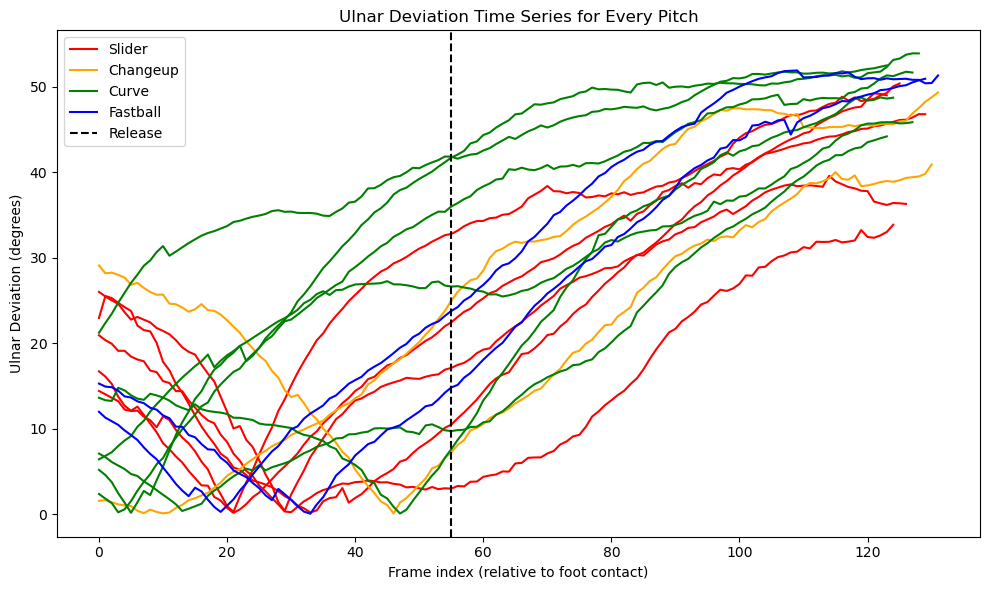

In [6]:
# Sqme as above but creates reference data table for comparisons

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically, selected_folder = "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"
#   so that the .c3d files within that folder are processed.

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_ulnar_deviation(points, marker_indices, frame):
    # Markers
    R = points[:3, marker_indices["Wrist_Radius"], frame]  # radius styloid
    U = points[:3, marker_indices["Wrist_Ulna"], frame]    # ulna styloid
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Midpoints
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Vectors
    forearm_vec = E_center - W_center
    radial_vec  = R - U
    hand_vec    = H - W_center

    # Normalize the forearm axis
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Project vectors onto plane orthogonal to the forearm axis
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit)*forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit)*forearm_unit

    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0

    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj   / np.linalg.norm(hand_proj)

    cross_val = np.cross(radial_proj_n, hand_proj_n)
    dot_val   = np.dot(radial_proj_n, hand_proj_n)
    # Use arctan2 for a robust angle measurement
    angle_rad = np.arctan2(np.linalg.norm(cross_val), dot_val)
    sign = np.sign(np.dot(cross_val, forearm_unit))
    angle_deg = np.degrees(angle_rad) * sign

    # Adjust the computed angle to reflect deviation from a neutral (nearly 180°) position.
    # For example, if a neutral configuration yields an angle of about 180°, then:
    angle_deg_corrected = 180 - abs(angle_deg)
    
    return angle_deg_corrected




def compute_pronation(points, marker_indices, frame):
    """
    Returns approximate pronation/supination angle in degrees.
    Positive => pronation, Negative => supination.
    """
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Vector from wrist_ulna to wrist_radius
    # or from center to radius, etc. 
    # We'll measure the angle around the forearm axis
    # for the "radius-ulna" line. 
    wrist_vec = R - U

    # Project wrist_vec onto plane orthonormal to forearm
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    # For reference, let's define a "neutral" vector. For simplicity,
    # we can define "neutral" as pointing straight up in the plane, or
    # define it from a known "zero" frame. But let's do a small hack:
    # We'll define the medial-lateral direction of the elbow as a reference.
    # It's an approximation.
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0  # Can't define angle

    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)

    cross_val  = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val    = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """Example computations (or placeholders) for entire range of frames."""
    flexion_angles = []
    pronation_angles = []

    for frame in range(start_frame, end_frame):
        # Some placeholder logic
        flexion_angles.append(0.0)    # Replace with your actual angle logic
        pronation_angles.append(0.0)  # Replace with your actual angle logic

    return flexion_angles, pronation_angles

def find_local_events(c3d, frame_rate, total_frames):
    """Given the presence of 'Foot Contact' and 'Release' events, find frames."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]  # row=1 => actual times

    # We'll handle both events below. You may adjust naming as needed:
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]

    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest

    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_local, release_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """Return arrays for (forearm) and (hand) segments so they can be plotted in Dash."""
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments

# Dictionary for storing pitch data for Dash
all_pitches = {}

# Create one single table if you prefer, or create multiple. This example creates one table "pitch_data".
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_file_path in c3d_files:
    # Normalize the path to ensure correct separators
    normalized_path = os.path.normpath(c3d_file_path)
    path_parts = normalized_path.split(os.sep)
    print("Path parts:", path_parts)  # Debug: see the parts of the path

    # Ensure there are at least 3 parts (participant, date, filename)
    if len(path_parts) < 3:
        print("Unexpected file path format:", c3d_file_path)
        continue

    # (a) Participant name from the third-to-last folder:
    participant_folder = path_parts[-3]  # e.g., "Bobby Wahl_BW"
    participant_name = participant_folder.rsplit("_", 1)[0]  # "Bobby Wahl"

    # (b) Date folder from the second-to-last folder:
    date_folder = path_parts[-2]  # e.g., "2025-02-05_"
    pitch_date = date_folder.rstrip("_")  # "2025-02-05"

    # (c) Pitch type from the filename:
    filename_only = path_parts[-1]  # e.g., "Slider RH 3.c3d"
    filename_noext = os.path.splitext(filename_only)[0]  # e.g., "Slider RH 3"
    pitch_type = filename_noext.split()[0].capitalize()  # e.g., "Slider"

    # (d) Full file path remains unchanged:
    full_file_path = c3d_file_path

    print("Participant:", participant_name)
    print("Pitch Date:", pitch_date)
    print("Pitch Type:", pitch_type)
    print("Full File Path:", full_file_path)


    # ----------------------------------------------------------
    # 2) Read the C3D
    # ----------------------------------------------------------
    print(f"Processing: {c3d_file_path}")
    c3d = ezc3d.c3d(c3d_file_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Low-pass filter the data before computing angles:
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = lowpass_filter(points[:3, i, :], cutoff=10, fs=frame_rate)

    # (d) Find events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # (e) Make sure we have frames after release
    if release_frame + 20 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
        continue

    # Region of interest
    start_frame = foot_contact_frame
    end_frame = release_frame + 70  # Switch to total_frames if I want to switch to whole trial
    release_index = release_frame - foot_contact_frame

    # (f) Confirm needed markers exist
    # You can rename these if the actual marker labels differ
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    marker_labels = clean_labels

    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker '{mk}' not found.")
            marker_indices = None
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not marker_indices:
        continue

    # ----------------------------------------------------------
    # 3) Compute angles or positions you need
    # ----------------------------------------------------------
    # Example: compute angles from midway to release+20
    flexion_angles, pronation_angles = compute_wrist_flexion_pronation(
        points, marker_indices, start_frame=start_frame, end_frame=end_frame
    )

    # For the 3D segments we want to animate in Dash:
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=start_frame, end_frame=end_frame
    )
        
    # Compute ulnar deviation time series from midway to release+20 frames
    ulnar_dev_series = []
    for frame in range(start_frame, end_frame):
        ulnar_dev_series.append(compute_ulnar_deviation(points, marker_indices, frame))
    
    # Update or initialize the in-memory dictionary for this pitch type
    if pitch_type not in all_pitches:
        all_pitches[pitch_type] = {
            "ulnar_dev_series": [ulnar_dev_series],
            "forearm": [forearm_segments],
            "hand": [hand_segments],
            "flexion": [flexion_angles],
            "pronation": [pronation_angles]
        }
    else:
        all_pitches[pitch_type]["ulnar_dev_series"].append(ulnar_dev_series)
        all_pitches[pitch_type]["forearm"].append(forearm_segments)
        all_pitches[pitch_type]["hand"].append(hand_segments)
        all_pitches[pitch_type]["flexion"].append(flexion_angles)
        all_pitches[pitch_type]["pronation"].append(pronation_angles)
    
    # Compute the key angles for insertion into SQLite (this always executes)
    # Use total_frames - 1 to get the final frame
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, total_frames - 1)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]
    
    mid_pro = compute_pronation(points, marker_indices, total_frames - 1)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    
    # Insert row into the single "pitch_data" table
    insert_sql = """
    INSERT INTO pitch_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """
    
    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        filename_only,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)


# Commit once at the end
conn.commit()
conn.close()


# Load your pitch_data averages
conn = sqlite3.connect("pitch_analysis.sqlite")
pitch_df = pd.read_sql_query("SELECT * FROM pitch_data", conn)
conn.close()

# Compute averages per pitch type from pitch_data
pitch_summary = pitch_df.groupby("pitch_type").agg({
    "rel_u_dev": "mean",
    "frame2_u_dev": "mean",
    "frame4_u_dev": "mean",
    "frame6_u_dev": "mean",
    "frame8_u_dev": "mean",
    "frame10_u_dev": "mean"
}).reset_index()

# Load your reference_data table
conn = sqlite3.connect("pitch_analysis.sqlite")
ref_df = pd.read_sql_query("SELECT * FROM reference_data", conn)
conn.close()

# Compute averages per pitch type from reference_data
ref_summary = ref_df.groupby("pitch_type").agg({
    "rel_u_dev": "mean",
    "frame2_u_dev": "mean",
    "frame4_u_dev": "mean",
    "frame6_u_dev": "mean",
    "frame8_u_dev": "mean",
    "frame10_u_dev": "mean"
}).reset_index()

# Merge the two summaries on pitch_type.
# Suffixes differentiate the selected data from the reference.
merged = pitch_summary.merge(ref_summary, on="pitch_type", suffixes=("_selected", "_reference"))

# Compute difference columns (selected minus reference)
merged["diff_rel_u_dev"]    = merged["rel_u_dev_selected"]    - merged["rel_u_dev_reference"]
merged["diff_frame2_u_dev"] = merged["frame2_u_dev_selected"] - merged["frame2_u_dev_reference"]
merged["diff_frame4_u_dev"] = merged["frame4_u_dev_selected"] - merged["frame4_u_dev_reference"]
merged["diff_frame6_u_dev"] = merged["frame6_u_dev_selected"] - merged["frame6_u_dev_reference"]
merged["diff_frame8_u_dev"] = merged["frame8_u_dev_selected"] - merged["frame8_u_dev_reference"]
merged["diff_frame10_u_dev"] = merged["frame10_u_dev_selected"] - merged["frame10_u_dev_reference"]

# Now, build a new DataFrame with two rows per pitch type:
rows = []
for _, row in merged.iterrows():
    pitch = row["pitch_type"]
    # Row for the selected data
    rows.append({
         "pitch_type": pitch,
         "rel_u_dev": row["rel_u_dev_selected"],
         "frame2_u_dev": row["frame2_u_dev_selected"],
         "frame4_u_dev": row["frame4_u_dev_selected"],
         "frame6_u_dev": row["frame6_u_dev_selected"],
         "frame8_u_dev": row["frame8_u_dev_selected"],
         "frame10_u_dev": row["frame10_u_dev_selected"]
    })
    # Row for the comparison (difference)
    rows.append({
         "pitch_type": f"{pitch} Comp",
         "rel_u_dev": row["diff_rel_u_dev"],
         "frame2_u_dev": row["diff_frame2_u_dev"],
         "frame4_u_dev": row["diff_frame4_u_dev"],
         "frame6_u_dev": row["diff_frame6_u_dev"],
         "frame8_u_dev": row["diff_frame8_u_dev"],
         "frame10_u_dev": row["diff_frame10_u_dev"]
    })

final_df = pd.DataFrame(rows)

# Round numeric columns to one decimal place.
final_df = final_df.round(1)

print("Comparison Table:")
print(final_df)


# Choose a target length for all series (e.g., 300 points)
target_length = 300

# Create a new dictionary for resampled (and averaged) series per pitch type.
avg_series_resampled = {}

# Define a color mapping for each pitch type.
# Add or adjust keys and colors as needed.
color_mapping = {
    "Fastball": "blue",
    "Slider": "red",
    "Curve": "green",
    "Changeup": "orange"
}

plt.figure(figsize=(10, 6))
plotted_labels = set()  # To avoid duplicate legend labels

# Loop over each pitch type in your all_pitches dictionary.
for pt, data in all_pitches.items():
    # Determine the color for this pitch type.
    color = color_mapping.get(pt, "black")  # default to black if not found
    # Loop over each throw's ulnar deviation series.
    for series in data["ulnar_dev_series"]:
        # Create an x-axis for this series.
        x = np.arange(len(series))
        # Only add a label the first time we plot a throw for this pitch type.
        label = pt if pt not in plotted_labels else None
        if label is not None:
            plotted_labels.add(pt)
        plt.plot(x, series, color=color, label=label)

# Optionally, mark the release event on the plot.
# For instance, if release_index is computed relative to foot contact:
plt.axvline(x=release_index, color='k', linestyle='--', label='Release')

plt.xlabel("Frame index (relative to foot contact)")
plt.ylabel("Ulnar Deviation (degrees)")
plt.title("Ulnar Deviation Time Series for Every Pitch")
plt.legend()
plt.tight_layout()
plt.show()

Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Reference Data_RD', '2025-02-21_', 'Slider RH 3.c3d']
Participant: Reference Data
Pitch Date: 2025-02-21
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Reference Data_RD/2025-02-21_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Reference Data_RD/2025-02-21_\Slider RH 3.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Reference Data_RD', '2025-02-21_', 'Slider RH 2.c3d']
Participant: Reference Data
Pitch Date: 2025-02-21
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Reference Data_RD/2025-02-21_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Reference Data_RD/2025-02-21_\Slider RH 2.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Reference Data_RD', '2025-02-21_', 'Slider RH 1.c3d']
Participant: Reference Data
Pitch Date: 2025-02-21
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Reference Data_RD/2025-02-21_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Re

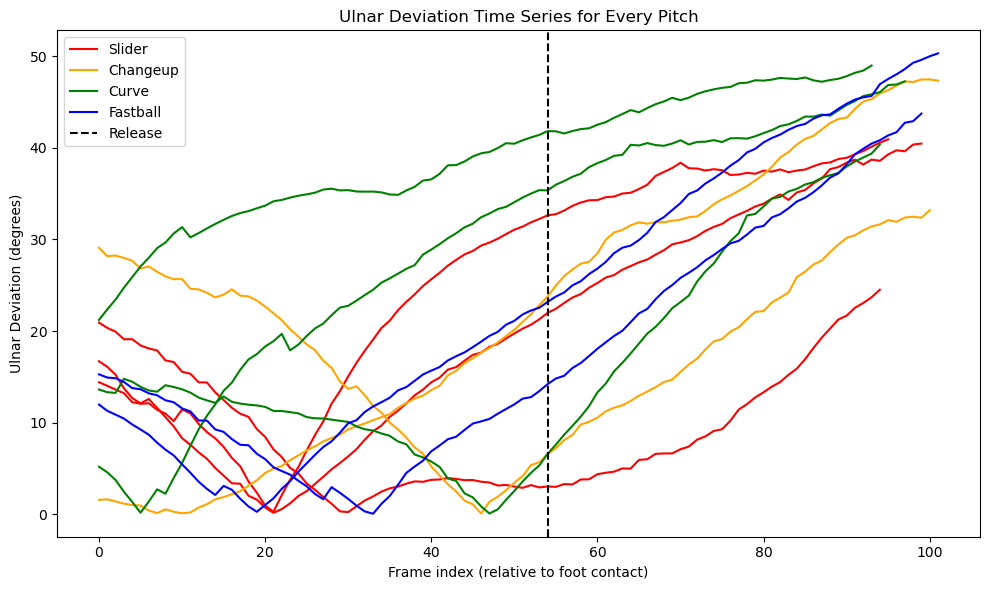

In [3]:
# Same as above but creates reference data table for comparisons

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt


# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically, selected_folder = "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"
#   so that the .c3d files within that folder are processed.

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_ulnar_deviation(points, marker_indices, frame):
    # Markers
    R = points[:3, marker_indices["Wrist_Radius"], frame]  # radius styloid
    U = points[:3, marker_indices["Wrist_Ulna"], frame]    # ulna styloid
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Midpoints
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Vectors
    forearm_vec = E_center - W_center
    radial_vec  = R - U
    hand_vec    = H - W_center

    # Normalize the forearm axis
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Project vectors onto plane orthogonal to the forearm axis
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit)*forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit)*forearm_unit

    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0

    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj   / np.linalg.norm(hand_proj)

    cross_val = np.cross(radial_proj_n, hand_proj_n)
    dot_val   = np.dot(radial_proj_n, hand_proj_n)
    # Use arctan2 for a robust angle measurement
    angle_rad = np.arctan2(np.linalg.norm(cross_val), dot_val)
    sign = np.sign(np.dot(cross_val, forearm_unit))
    angle_deg = np.degrees(angle_rad) * sign

    # Adjust the computed angle to reflect deviation from a neutral (nearly 180°) position.
    # For example, if a neutral configuration yields an angle of about 180°, then:
    angle_deg_corrected = 180 - abs(angle_deg)
    
    return angle_deg_corrected




def compute_pronation(points, marker_indices, frame):
    """
    Returns approximate pronation/supination angle in degrees.
    Positive => pronation, Negative => supination.
    """
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Vector from wrist_ulna to wrist_radius
    # or from center to radius, etc. 
    # We'll measure the angle around the forearm axis
    # for the "radius-ulna" line. 
    wrist_vec = R - U

    # Project wrist_vec onto plane orthonormal to forearm
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    # For reference, let's define a "neutral" vector. For simplicity,
    # we can define "neutral" as pointing straight up in the plane, or
    # define it from a known "zero" frame. But let's do a small hack:
    # We'll define the medial-lateral direction of the elbow as a reference.
    # It's an approximation.
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0  # Can't define angle

    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)

    cross_val  = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val    = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """Example computations (or placeholders) for entire range of frames."""
    flexion_angles = []
    pronation_angles = []

    for frame in range(start_frame, end_frame):
        # Some placeholder logic
        flexion_angles.append(0.0)    # Replace with your actual angle logic
        pronation_angles.append(0.0)  # Replace with your actual angle logic

    return flexion_angles, pronation_angles

def find_local_events(c3d, frame_rate, total_frames):
    """Given the presence of 'Foot Contact' and 'Release' events, find frames."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]  # row=1 => actual times

    # We'll handle both events below. You may adjust naming as needed:
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]

    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest

    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_local, release_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """Return arrays for (forearm) and (hand) segments so they can be plotted in Dash."""
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments

# Dictionary for storing pitch data for Dash
all_pitches = {}

# Create one single table if you prefer, or create multiple. This example creates one table "pitch_data".
cursor.execute("""
CREATE TABLE IF NOT EXISTS reference_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_file_path in c3d_files:
    # Normalize the path to ensure correct separators
    normalized_path = os.path.normpath(c3d_file_path)
    path_parts = normalized_path.split(os.sep)
    print("Path parts:", path_parts)  # Debug: see the parts of the path

    # Ensure there are at least 3 parts (participant, date, filename)
    if len(path_parts) < 3:
        print("Unexpected file path format:", c3d_file_path)
        continue

    # (a) Participant name from the third-to-last folder:
    participant_folder = path_parts[-3]  # e.g., "Bobby Wahl_BW"
    participant_name = participant_folder.rsplit("_", 1)[0]  # "Bobby Wahl"

    # (b) Date folder from the second-to-last folder:
    date_folder = path_parts[-2]  # e.g., "2025-02-05_"
    pitch_date = date_folder.rstrip("_")  # "2025-02-05"

    # (c) Pitch type from the filename:
    filename_only = path_parts[-1]  # e.g., "Slider RH 3.c3d"
    filename_noext = os.path.splitext(filename_only)[0]  # e.g., "Slider RH 3"
    pitch_type = filename_noext.split()[0].capitalize()  # e.g., "Slider"

    # (d) Full file path remains unchanged:
    full_file_path = c3d_file_path

    print("Participant:", participant_name)
    print("Pitch Date:", pitch_date)
    print("Pitch Type:", pitch_type)
    print("Full File Path:", full_file_path)


    # ----------------------------------------------------------
    # 2) Read the C3D
    # ----------------------------------------------------------
    print(f"Processing: {c3d_file_path}")
    c3d = ezc3d.c3d(c3d_file_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Low-pass filter the data before computing angles:
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = lowpass_filter(points[:3, i, :], cutoff=10, fs=frame_rate)

    # (d) Find events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # (e) Make sure we have frames after release
    if release_frame + 20 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
        continue

    # Region of interest
    start_frame = foot_contact_frame
    end_frame = release_frame + 40  # Switch to total_frames if I want to switch to whole trial
    release_index = release_frame - foot_contact_frame

    # (f) Confirm needed markers exist
    # You can rename these if the actual marker labels differ
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    marker_labels = clean_labels

    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker '{mk}' not found.")
            marker_indices = None
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not marker_indices:
        continue

    # ----------------------------------------------------------
    # 3) Compute angles or positions you need
    # ----------------------------------------------------------
    # Example: compute angles from midway to release+20
    flexion_angles, pronation_angles = compute_wrist_flexion_pronation(
        points, marker_indices, start_frame=start_frame, end_frame=end_frame
    )

    # For the 3D segments we want to animate in Dash:
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=start_frame, end_frame=end_frame
    )
        
    # Compute ulnar deviation time series from midway to release+20 frames
    ulnar_dev_series = []
    for frame in range(start_frame, end_frame):
        ulnar_dev_series.append(compute_ulnar_deviation(points, marker_indices, frame))
    
    # Update or initialize the in-memory dictionary for this pitch type
    if pitch_type not in all_pitches:
        all_pitches[pitch_type] = {
            "ulnar_dev_series": [ulnar_dev_series],
            "forearm": [forearm_segments],
            "hand": [hand_segments],
            "flexion": [flexion_angles],
            "pronation": [pronation_angles]
        }
    else:
        all_pitches[pitch_type]["ulnar_dev_series"].append(ulnar_dev_series)
        all_pitches[pitch_type]["forearm"].append(forearm_segments)
        all_pitches[pitch_type]["hand"].append(hand_segments)
        all_pitches[pitch_type]["flexion"].append(flexion_angles)
        all_pitches[pitch_type]["pronation"].append(pronation_angles)
    
    # Compute the key angles for insertion into SQLite (this always executes)
    # Use total_frames - 1 to get the final frame
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, total_frames - 1)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]
    
    mid_pro = compute_pronation(points, marker_indices, total_frames - 1)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    
    # Insert row into the single "pitch_data" table
    insert_sql = """
    INSERT INTO reference_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """
    
    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        filename_only,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)


# Commit once at the end
conn.commit()
conn.close()


# Connect and load all pitch_data into a DataFrame.
conn = sqlite3.connect("pitch_analysis.sqlite")
df = pd.read_sql_query("SELECT * FROM pitch_data", conn)
conn.close()

# Compute averages by pitch type for the selected frames.
# (Assuming frame2_u_dev corresponds to 2 frames after release, etc.)
summary = df.groupby("pitch_type").agg({
    "rel_u_dev": "mean",
    "frame2_u_dev": "mean",
    "frame4_u_dev": "mean",
    "frame6_u_dev": "mean",
    "frame8_u_dev": "mean",
    "frame10_u_dev": "mean"
}).reset_index()

# Compute an example “flick” magnitude as the difference between frame10 and release.
summary["flick_mag"] = summary["frame10_u_dev"] - summary["rel_u_dev"]

# Optionally, you can also compare these values to the averages from the rest of the DB
# (if you have other baseline values stored) and compute a difference.
# For example, if you had a baseline column "baseline_u_dev", you might do:
# summary["avg_diff"] = summary["rel_u_dev"] - df["baseline_u_dev"].mean()

print("Summary Table (averages by pitch type):")
print(summary)

# Choose a target length for all series (e.g., 300 points)
target_length = 300

# Create a new dictionary for resampled (and averaged) series per pitch type.
avg_series_resampled = {}

# Define a color mapping for each pitch type.
# Add or adjust keys and colors as needed.
color_mapping = {
    "Fastball": "blue",
    "Slider": "red",
    "Curve": "green",
    "Changeup": "orange"
}

plt.figure(figsize=(10, 6))
plotted_labels = set()  # To avoid duplicate legend labels

# Loop over each pitch type in your all_pitches dictionary.
for pt, data in all_pitches.items():
    # Determine the color for this pitch type.
    color = color_mapping.get(pt, "black")  # default to black if not found
    # Loop over each throw's ulnar deviation series.
    for series in data["ulnar_dev_series"]:
        # Create an x-axis for this series.
        x = np.arange(len(series))
        # Only add a label the first time we plot a throw for this pitch type.
        label = pt if pt not in plotted_labels else None
        if label is not None:
            plotted_labels.add(pt)
        plt.plot(x, series, color=color, label=label)

# Optionally, mark the release event on the plot.
# For instance, if release_index is computed relative to foot contact:
plt.axvline(x=release_index, color='k', linestyle='--', label='Release')

plt.xlabel("Frame index (relative to foot contact)")
plt.ylabel("Ulnar Deviation (degrees)")
plt.title("Ulnar Deviation Time Series for Every Pitch")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# attempted addition of proper flexion graphs and updated sql schema but the dash board doesnt populate properly. No idea whats going on with it the o3 model really fucked it up

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import plotly.graph_objects as go



# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically, selected_folder = "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"
#   so that the .c3d files within that folder are processed.

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_ulnar_deviation(points, marker_indices, frame):
    """
    Returns approximate radial/ulnar deviation angle in degrees.
    Positive => ulnar deviation, Negative => radial deviation.
    """
    # Markers
    R = points[:3, marker_indices["Wrist_Radius"], frame]  # radius styloid
    U = points[:3, marker_indices["Wrist_Ulna"], frame]    # ulna styloid
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Midpoints
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Vectors
    forearm_vec = E_center - W_center   # wrist->elbow
    radial_vec  = R - U                # ulna->radius
    hand_vec    = H - W_center         # wrist->hand

    # Normalize the "forearm axis"
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Project radial_vec & hand_vec onto plane orthonormal to forearm
    #   because we only want the radial/ulnar angle in that plane
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit) * forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit) * forearm_unit

    # Normalize
    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0  # Degenerate case, no well-defined angle

    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj   / np.linalg.norm(hand_proj)

    # Signed angle: cross product & dot product
    cross_val  = np.cross(radial_proj_n, hand_proj_n)
    dot_val    = np.dot(radial_proj_n, hand_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))  # + or -

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_pronation(points, marker_indices, frame):
    """
    Returns approximate pronation/supination angle in degrees.
    Positive => pronation, Negative => supination.
    """
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Vector from wrist_ulna to wrist_radius
    # or from center to radius, etc. 
    # We'll measure the angle around the forearm axis
    # for the "radius-ulna" line. 
    wrist_vec = R - U

    # Project wrist_vec onto plane orthonormal to forearm
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    # For reference, let's define a "neutral" vector. For simplicity,
    # we can define "neutral" as pointing straight up in the plane, or
    # define it from a known "zero" frame. But let's do a small hack:
    # We'll define the medial-lateral direction of the elbow as a reference.
    # It's an approximation.
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0  # Can't define angle

    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)

    cross_val  = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val    = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """Example computations (or placeholders) for entire range of frames."""
    flexion_angles = []
    pronation_angles = []

    for frame in range(start_frame, end_frame):
        # Some placeholder logic
        flexion_angles.append(0.0)    # Replace with your actual angle logic
        pronation_angles.append(0.0)  # Replace with your actual angle logic

    return flexion_angles, pronation_angles

def find_local_events(c3d, frame_rate, total_frames):
    """Given the presence of 'Foot Contact' and 'Release' events, find frames."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]  # row=1 => actual times

    # We'll handle both events below. You may adjust naming as needed:
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]

    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest

    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_local, release_local

all_pitches={}

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """Return arrays for (forearm) and (hand) segments so they can be plotted in Dash."""
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments

    # 1) Build full per-frame ulnar & pronation arrays from [midway_frame .. frame_after_20)
    ulnar_array = []
    pron_array = []
    for fr in range(midway_frame, frame_after_20):
        ulnar_array.append(compute_ulnar_deviation(points, marker_indices, fr))
        pron_array.append(compute_pronation(points, marker_indices, fr))
    
    # 2) If you truly have a wrist flexion routine, do it here:
    #    e.g. compute_flexion(points, marker_indices, fr)
    #    Right now, your "compute_wrist_flexion_pronation" is just placeholders=0.0
    #    but if you eventually have real flexion logic, store it similarly:
    flex_array = []
    for fr in range(midway_frame, frame_after_20):
        # Right now you only have a placeholder for flexion = 0
        flex_array.append(0.0)
    
    # 3) Store these arrays into your in-memory dictionary for plotting:
    all_pitches[pitch_type] = {
        "forearm": forearm_segments,
        "hand": hand_segments,
        "ulnar": ulnar_array,
        "pronation": pron_array,
        "flexion": flex_array
    }


# Create one single table if you prefer, or create multiple. This example creates one table "pitch_data".
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_file_path in c3d_files:
    # Normalize the path to ensure correct separators
    normalized_path = os.path.normpath(c3d_file_path)
    path_parts = normalized_path.split(os.sep)
    print("Path parts:", path_parts)  # Debug: see the parts of the path

    # Ensure there are at least 3 parts (participant, date, filename)
    if len(path_parts) < 3:
        print("Unexpected file path format:", c3d_file_path)
        continue

    # (a) Participant name from the third-to-last folder:
    participant_folder = path_parts[-3]  # e.g., "Bobby Wahl_BW"
    participant_name = participant_folder.rsplit("_", 1)[0]  # "Bobby Wahl"

    # (b) Date folder from the second-to-last folder:
    date_folder = path_parts[-2]  # e.g., "2025-02-05_"
    pitch_date = date_folder.rstrip("_")  # "2025-02-05"

    # (c) Pitch type from the filename:
    filename_only = path_parts[-1]  # e.g., "Slider RH 3.c3d"
    filename_noext = os.path.splitext(filename_only)[0]  # e.g., "Slider RH 3"
    pitch_type = filename_noext.split()[0].capitalize()  # e.g., "Slider"

    # (d) Full file path remains unchanged:
    full_file_path = c3d_file_path

    print("Participant:", participant_name)
    print("Pitch Date:", pitch_date)
    print("Pitch Type:", pitch_type)
    print("Full File Path:", full_file_path)


    # ----------------------------------------------------------
    # 2) Read the C3D
    # ----------------------------------------------------------
    print(f"Processing: {c3d_file_path}")
    c3d = ezc3d.c3d(c3d_file_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Low-pass filter the data before computing angles:
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = lowpass_filter(points[:3, i, :], cutoff=10, fs=frame_rate)

    # (d) Find events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # (e) Make sure we have frames after release
    if release_frame + 20 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
        continue

    # Region of interest
    frame_after_20 = release_frame + 20
    midway_frame   = (foot_contact_frame + release_frame) // 2

    # (f) Confirm needed markers exist
    # You can rename these if the actual marker labels differ
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    marker_labels = clean_labels

    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker '{mk}' not found.")
            marker_indices = None
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not marker_indices:
        continue

    # ----------------------------------------------------------
    # 3) Compute angles or positions you need
    # ----------------------------------------------------------
    # Example: compute angles from midway to release+20
    flexion_angles, pronation_angles = compute_wrist_flexion_pronation(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # For the 3D segments we want to animate in Dash:
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # Insert or update the main dictionary for visualization in Dash
    if pitch_type not in all_pitches:
        all_pitches[pitch_type] = {
            "forearm": forearm_segments,
            "hand": hand_segments,
            "flexion": flexion_angles,
            "pronation": pronation_angles
        }
    else:
        # If you want to handle multiple throws of the same pitch type,
        # you might either extend or overwrite. This example overwrites
        # for clarity. You can also store them in a list if needed.
        all_pitches[pitch_type] = {
            "forearm": forearm_segments,
            "hand": hand_segments,
            "flexion": flexion_angles,
            "pronation": pronation_angles
        }

    # 4) Insert into SQLite
    #
    # Actually compute the key angles at mid, release, +10 frames, etc.:
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, midway_frame)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    mid_pro = compute_pronation(points, marker_indices, midway_frame)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    # Insert row into the single "pitch_data" table
    insert_sql = """
    INSERT INTO pitch_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """

    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        filename_only,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)

# Commit once at the end
conn.commit()
conn.close()

# ============================ DASH APP ============================
# ============================ 1. Load and Group Database Data ============================
db_path = "pitch_analysis.sqlite"  # Adjust path if needed
conn = sqlite3.connect(db_path)
# Load the entire pitch_data table into a DataFrame
df = pd.read_sql_query("SELECT * FROM pitch_data", conn)
conn.close()

# Ensure column names are lowercase
df.columns = [col.lower() for col in df.columns]

# Build a nested dictionary:
# all_pitches_db[participant_name][pitch_date][filename] = row_dict
all_pitches_db = {}
for idx, row in df.iterrows():
    row_dict = row.to_dict()
    participant = row_dict["participant_name"]
    pitch_date = row_dict["pitch_date"]
    filename = row_dict["filename"]  # We'll use the full file path stored in the DB
    if participant not in all_pitches_db:
        all_pitches_db[participant] = {}
    if pitch_date not in all_pitches_db[participant]:
        all_pitches_db[participant][pitch_date] = {}
    all_pitches_db[participant][pitch_date][filename] = row_dict

# ============================ 2. Helper Functions for Time Series ============================

def get_u_dev_series(pitch_data):
    """
    Returns a list of [mid_u_dev, rel_u_dev, frame1_u_dev, ..., frame10_u_dev].
    """
    keys = [
        "mid_u_dev",     # midpoint
        "rel_u_dev",     # release
        "frame1_u_dev",
        "frame2_u_dev",
        "frame3_u_dev",
        "frame4_u_dev",
        "frame5_u_dev",
        "frame6_u_dev",
        "frame7_u_dev",
        "frame8_u_dev",
        "frame9_u_dev",
        "frame10_u_dev"
    ]
    series = [pitch_data.get(k, None) for k in keys]
    # Filter out Nones in case not all columns exist
    return [x for x in series if x is not None]


def get_pronation_series(pitch_data):
    """
    Returns a list of [mid_pronation, rel_pronation, frame1_pronation, ..., frame10_pronation].
    """
    keys = [
        "mid_pronation",
        "rel_pronation",
        "frame1_pronation",
        "frame2_pronation",
        "frame3_pronation",
        "frame4_pronation",
        "frame5_pronation",
        "frame6_pronation",
        "frame7_pronation",
        "frame8_pronation",
        "frame9_pronation",
        "frame10_pronation"
    ]
    series = [pitch_data.get(k, None) for k in keys]
    return [x for x in series if x is not None]


def get_flexion_series(pitch_data):
    """
    Returns a list of [mid_flexion, rel_flexion, frame1_flexion, ..., frame10_flexion].
    Make sure these columns actually exist in your DB if you want real data.
    If they do not exist yet, you would need to add them to your CREATE TABLE
    and INSERT statements (similar to how ulnar_dev and pronation are stored).
    """
    keys = [
        "mid_flexion",
        "rel_flexion",
        "frame1_flexion",
        "frame2_flexion",
        "frame3_flexion",
        "frame4_flexion",
        "frame5_flexion",
        "frame6_flexion",
        "frame7_flexion",
        "frame8_flexion",
        "frame9_flexion",
        "frame10_flexion"
    ]
    series = [pitch_data.get(k, None) for k in keys]
    return [x for x in series if x is not None]

# ============================ 3. Color Mapping ============================
pitch_color_map = {
    "Curve": "#32CD32", 
    "Fastball": "#FF0000",
    "Changeup": "green",
    "Slider": "yellow",
    "Cutter": "#FF0000"
}

# ============================ 4. Graph Creation Functions ============================
# Note: These functions use the time series from the database row.
# You may adjust the plotting as needed.

def create_3d_figure(pitch_data, view="rear", frame_idx=0):
    # For demonstration, we plot the flexion series as a dummy 3D line.
    flexion_series = get_flexion_series(pitch_data)
    frames = list(range(len(flexion_series)))
    color = "blue"
    fig = go.Figure()
    # Dummy 3D plot: x=frame, y=flexion, z=0
    fig.add_trace(go.Scatter3d(
        x=frames,
        y=flexion_series,
        z=[0]*len(frames),
        mode="lines",
        line=dict(color=color, width=5),
        name="3D Flexion"
    ))
    fig.update_layout(title=f"3D View - Frame {frame_idx}",
                      scene=dict(xaxis_title="Frame", yaxis_title="Flexion", zaxis_title=""))
    return fig

def create_2d_figure(pitch_data, x_axis="x", y_axis="z"):
    # Dummy 2D plot using flexion series
    flexion_series = get_flexion_series(pitch_data)
    frames = list(range(len(flexion_series)))
    color = "blue"
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=flexion_series,
        mode="lines",
        line=dict(color=color, width=2),
        name="2D Flexion"
    ))
    fig.update_layout(title=f"2D {y_axis.upper()} vs. {x_axis.upper()}",
                      xaxis_title="Frame", yaxis_title="Flexion")
    return fig

def create_ulnar_graph(pitch_data, frame_idx):
    # 1) Grab the pitch_type from the DB row so we know which in-memory angles to use
    pitch_type = pitch_data.get("pitch_type", None)
    if pitch_type not in all_pitches:
        # Safety check: if not found, return an empty fig
        return go.Figure()

    # 2) Retrieve the full frame-by-frame array we stored in all_pitches
    u_dev_series = all_pitches[pitch_type]["ulnar"]
    frames = list(range(len(u_dev_series)))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=u_dev_series,
        mode="lines",
        line=dict(color="blue"),
        name="Ulnar Deviation"
    ))

    # Optional vertical lines for "release" or the current slider frame
    # If you want frame 0 == "midway," then "release" is at (release_frame - midway_frame).
    # We don’t strictly know that number here, but you can approximate:
    release_index = (len(u_dev_series)//2)  # or some known offset if you prefer
    fig.add_vline(x=release_index, line_color="blue", line_dash="dot")
    fig.add_vline(x=frame_idx,     line_color="black", line_dash="dash")

    fig.update_layout(
        title="Ulnar/Radial Deviation",
        xaxis_title="Frame (midway->release+20)",
        yaxis_title="Angle (deg)"
    )
    return fig


def create_pronation_graph(pitch_data, frame_idx):
    pitch_type = pitch_data.get("pitch_type", None)
    if pitch_type not in all_pitches:
        return go.Figure()

    pronation_series = all_pitches[pitch_type]["pronation"]
    frames = list(range(len(pronation_series)))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=pronation_series,
        mode="lines",
        line=dict(color="red"),
        name="Pronation/Supination"
    ))

    release_index = (len(pronation_series)//2)
    fig.add_vline(x=release_index, line_color="blue", line_dash="dot")
    fig.add_vline(x=frame_idx,     line_color="black", line_dash="dash")

    fig.update_layout(
        title="Pronation/Supination",
        xaxis_title="Frame (midway->release+20)",
        yaxis_title="Angle (deg)"
    )
    return fig


def create_flexion_graph(pitch_data, frame_idx):
    pitch_type = pitch_data.get("pitch_type", None)
    if pitch_type not in all_pitches:
        return go.Figure()

    flex_series = all_pitches[pitch_type]["flexion"]
    frames = list(range(len(flex_series)))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=flex_series,
        mode="lines",
        line=dict(color="green"),
        name="Flexion/Extension"
    ))

    release_index = (len(flex_series)//2)
    fig.add_vline(x=release_index, line_color="blue", line_dash="dot")
    fig.add_vline(x=frame_idx,     line_color="black", line_dash="dash")

    fig.update_layout(
        title="Flexion/Extension",
        xaxis_title="Frame (midway->release+20)",
        yaxis_title="Angle (deg)"
    )
    return fig


def create_angles_table(pitch_data):
    flexion_series = get_flexion_series(pitch_data)
    pronation_series = get_pronation_series(pitch_data)
    if not flexion_series or not pronation_series:
        return html.Div("No angle data available.")
    release_idx = len(flexion_series)//2
    flex_release = flexion_series[release_idx]
    pron_release = pronation_series[release_idx]
    segment = flexion_series[release_idx: min(release_idx+10, len(flexion_series))]
    mean_flex = np.mean(segment) if segment else 0.0
    normative = 20.0
    diff = mean_flex - normative
    row = {
        "Pitch": pitch_data.get("filename", "Unknown"),
        "Flexion @ Release": f"{flex_release:.1f}",
        "Pronation @ Release": f"{pron_release:.1f}",
        "Mean Flexion (Rel->+10)": f"{mean_flex:.1f}",
        "Diff from Norm (20deg)": f"{diff:+.1f}"
    }
    columns = [
        {"name": "Pitch", "id": "Pitch"},
        {"name": "Flexion @ Release", "id": "Flexion @ Release"},
        {"name": "Pronation @ Release", "id": "Pronation @ Release"},
        {"name": "Mean Flexion (Rel->+10)", "id": "Mean Flexion (Rel->+10)"},
        {"name": "Diff from Norm (20deg)", "id": "Diff from Norm (20deg)"}
    ]
    return dash_table.DataTable(
        data=[row],
        columns=columns,
        style_cell={"textAlign": "center", "padding": "5px"},
        style_header={"fontWeight": "bold", "backgroundColor": "#f7f7f7"},
        page_size=10
    )

# ============================ 5. Dash Layout ============================
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

app.layout = dbc.Container(fluid=True, children=[
    dbc.Row([
        dbc.Col(html.H3("Baseball Pitch Analysis", className="text-center text-primary mb-4"), width=12)
    ]),
    # --- Dropdowns for Filtering ---
    dbc.Row([
        dbc.Col([
            html.Label("Select Participant:"),
            dcc.Dropdown(
                id="participant-dropdown",
                options=[{"label": p, "value": p} for p in sorted(all_pitches_db.keys())],
                value=sorted(all_pitches_db.keys())[0] if all_pitches_db else None
            )
        ], md=4),
        dbc.Col([
            html.Label("Select Date:"),
            dcc.Dropdown(id="date-dropdown")
        ], md=4),
        dbc.Col([
            html.Label("Select Pitch:"),
            dcc.Dropdown(id="pitch-dropdown")
        ], md=4)
    ], className="mb-3"),
    
    # --- Top Controls: View and Frame Controls ---
    dbc.Row([
        dbc.Col([
            html.Label("Select View:"),
            dcc.RadioItems(
                id="view-toggle",
                options=[
                    {"label": "Rear (XY)", "value": "rear"},
                    {"label": "Side (XZ)", "value": "side"}
                ],
                value="rear",
                inline=True
            )
        ], md=4),
        dbc.Col([
            html.Label("Frame Controls:"),
            dcc.Slider(id="frame-slider", min=0, max=10, step=1, value=0),
            html.Div([
                dbc.Button("Play", id="play-button", color="success", className="me-2"),
                dbc.Button("Pause", id="pause-button", color="warning", className="me-2"),
            ], className="mt-2"),
            dcc.Interval(id="frame-interval", interval=300, n_intervals=0, disabled=True)
        ], md=8)
    ], className="mb-3"),
    
    # --- Main Graphs ---
    dbc.Row([
        dbc.Col(md=9, children=[
            dbc.Row([
                dbc.Col(dcc.Graph(id="pitch-graph-3d"), width=12)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="pitch-2d-1"), width=6),
                dbc.Col(dcc.Graph(id="pitch-2d-2"), width=6)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="ulnar-graph"), width=12)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="pronation-graph"), width=6),
                dbc.Col(dcc.Graph(id="flexion-graph"), width=6)
            ], className="mb-3")
        ]),
        dbc.Col(md=3, children=[
            html.H5("Angle Statistics"),
            html.Div(id="angle-table")
        ])
    ])
])
    
# ============================ 6. Callbacks ============================

# Dropdown callbacks
@app.callback(
    [Output("date-dropdown", "options"),
     Output("date-dropdown", "value")],
    [Input("participant-dropdown", "value")]
)
def update_date_dropdown(selected_participant):
    if not selected_participant:
        return [], None
    dates = sorted(all_pitches_db[selected_participant].keys())
    options = [{"label": d, "value": d} for d in dates]
    return options, dates[0] if dates else None

@app.callback(
    [Output("pitch-dropdown", "options"),
     Output("pitch-dropdown", "value")],
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value")]
)
def update_pitch_dropdown(selected_participant, selected_date):
    if not selected_participant or not selected_date:
        return [], None
    pitches = sorted(all_pitches_db[selected_participant].get(selected_date, {}).keys())
    options = [{"label": os.path.basename(p), "value": p} for p in pitches]
    return options, pitches[0] if pitches else None

# Graphs and table callback
@app.callback(
    [Output("pitch-graph-3d", "figure"),
     Output("pitch-2d-1", "figure"),
     Output("pitch-2d-2", "figure"),
     Output("ulnar-graph", "figure"),
     Output("pronation-graph", "figure"),
     Output("flexion-graph", "figure"),
     Output("frame-slider", "max"),
     Output("frame-slider", "value"),
     Output("frame-interval", "disabled")],
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value"),
     Input("pitch-dropdown", "value"),
     Input("view-toggle", "value"),
     Input("frame-slider", "value"),
     Input("play-button", "n_clicks"),
     Input("pause-button", "n_clicks"),
     Input("frame-interval", "n_intervals")],
    [State("frame-slider", "max")]
)
def update_all_graphs(selected_participant, selected_date, selected_pitch, view, frame_idx,
                      play_click, pause_click, n_int, old_max):
    # If selection is incomplete, return empty figures
    if not (selected_participant and selected_date and selected_pitch):
        empty_fig = go.Figure()
        return empty_fig, empty_fig, empty_fig, empty_fig, empty_fig, empty_fig, 10, 0, True

    # Retrieve the pitch data row from our nested dictionary
    pitch_data = all_pitches_db[selected_participant][selected_date][selected_pitch]
    
    # Build time series from the pitch data
    flexion_series = get_flexion_series(pitch_data)
    pronation_series = get_pronation_series(pitch_data)
    
    max_frames = len(flexion_series)
    if max_frames == 0:
        max_frames = 10

    ctx = dash.callback_context
    triggered_id = ctx.triggered[0]["prop_id"].split(".")[0] if ctx.triggered else None

    disabled_interval = True
    if triggered_id == "play-button":
        disabled_interval = False
    elif triggered_id == "pause-button":
        disabled_interval = True
    if triggered_id == "frame-interval" and not disabled_interval:
        frame_idx = (frame_idx + 1) % max_frames
    if frame_idx >= max_frames:
        frame_idx = 0

    # Create graphs using the pitch_data (which is a dictionary with DB fields)
    fig3d  = create_3d_figure(pitch_data, view, frame_idx)
    fig2d1 = create_2d_figure(pitch_data, "x", "z")
    fig2d2 = create_2d_figure(pitch_data, "y", "z")
    figU   = create_ulnar_graph(pitch_data, frame_idx)
    figP   = create_pronation_graph(pitch_data, frame_idx)
    figF   = create_flexion_graph(pitch_data, frame_idx)

    return (fig3d, fig2d1, fig2d2, figU, figP, figF,
            max_frames-1, frame_idx, disabled_interval)

@app.callback(
    Output("angle-table", "children"),
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value"),
     Input("pitch-dropdown", "value")]
)
def update_angle_table(selected_participant, selected_date, selected_pitch):
    if not (selected_participant and selected_date and selected_pitch):
        return html.Div("No pitch selected.")
    pitch_data = all_pitches_db[selected_participant][selected_date][selected_pitch]
    return create_angles_table(pitch_data)

# ============================ 7. Run the App ============================
if __name__ == "__main__":
    app.run_server(debug=True)


Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 3.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 2.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 1.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Path

In [8]:

# sql schema works and dash board is updated but graphs dont properly populate


import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import plotly.graph_objects as go



# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically, selected_folder = "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"
#   so that the .c3d files within that folder are processed.

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_ulnar_deviation(points, marker_indices, frame):
    """
    Returns approximate radial/ulnar deviation angle in degrees.
    Positive => ulnar deviation, Negative => radial deviation.
    """
    # Markers
    R = points[:3, marker_indices["Wrist_Radius"], frame]  # radius styloid
    U = points[:3, marker_indices["Wrist_Ulna"], frame]    # ulna styloid
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Midpoints
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Vectors
    forearm_vec = E_center - W_center   # wrist->elbow
    radial_vec  = R - U                # ulna->radius
    hand_vec    = H - W_center         # wrist->hand

    # Normalize the "forearm axis"
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Project radial_vec & hand_vec onto plane orthonormal to forearm
    #   because we only want the radial/ulnar angle in that plane
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit) * forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit) * forearm_unit

    # Normalize
    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0  # Degenerate case, no well-defined angle

    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj   / np.linalg.norm(hand_proj)

    # Signed angle: cross product & dot product
    cross_val  = np.cross(radial_proj_n, hand_proj_n)
    dot_val    = np.dot(radial_proj_n, hand_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))  # + or -

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_pronation(points, marker_indices, frame):
    """
    Returns approximate pronation/supination angle in degrees.
    Positive => pronation, Negative => supination.
    """
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Vector from wrist_ulna to wrist_radius
    # or from center to radius, etc. 
    # We'll measure the angle around the forearm axis
    # for the "radius-ulna" line. 
    wrist_vec = R - U

    # Project wrist_vec onto plane orthonormal to forearm
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    # For reference, let's define a "neutral" vector. For simplicity,
    # we can define "neutral" as pointing straight up in the plane, or
    # define it from a known "zero" frame. But let's do a small hack:
    # We'll define the medial-lateral direction of the elbow as a reference.
    # It's an approximation.
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0  # Can't define angle

    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)

    cross_val  = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val    = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """Example computations (or placeholders) for entire range of frames."""
    flexion_angles = []
    pronation_angles = []

    for frame in range(start_frame, end_frame):
        # Some placeholder logic
        flexion_angles.append(0.0)    # Replace with your actual angle logic
        pronation_angles.append(0.0)  # Replace with your actual angle logic

    return flexion_angles, pronation_angles

def find_local_events(c3d, frame_rate, total_frames):
    """Given the presence of 'Foot Contact' and 'Release' events, find frames."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]  # row=1 => actual times

    # We'll handle both events below. You may adjust naming as needed:
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]

    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest

    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_local, release_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """Return arrays for (forearm) and (hand) segments so they can be plotted in Dash."""
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments

# Dictionary for storing pitch data for Dash
all_pitches = {}

# Create one single table if you prefer, or create multiple. This example creates one table "pitch_data".
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_file_path in c3d_files:
    # Normalize the path to ensure correct separators
    normalized_path = os.path.normpath(c3d_file_path)
    path_parts = normalized_path.split(os.sep)
    print("Path parts:", path_parts)  # Debug: see the parts of the path

    # Ensure there are at least 3 parts (participant, date, filename)
    if len(path_parts) < 3:
        print("Unexpected file path format:", c3d_file_path)
        continue

    # (a) Participant name from the third-to-last folder:
    participant_folder = path_parts[-3]  # e.g., "Bobby Wahl_BW"
    participant_name = participant_folder.rsplit("_", 1)[0]  # "Bobby Wahl"

    # (b) Date folder from the second-to-last folder:
    date_folder = path_parts[-2]  # e.g., "2025-02-05_"
    pitch_date = date_folder.rstrip("_")  # "2025-02-05"

    # (c) Pitch type from the filename:
    filename_only = path_parts[-1]  # e.g., "Slider RH 3.c3d"
    filename_noext = os.path.splitext(filename_only)[0]  # e.g., "Slider RH 3"
    pitch_type = filename_noext.split()[0].capitalize()  # e.g., "Slider"

    # (d) Full file path remains unchanged:
    full_file_path = c3d_file_path

    print("Participant:", participant_name)
    print("Pitch Date:", pitch_date)
    print("Pitch Type:", pitch_type)
    print("Full File Path:", full_file_path)


    # ----------------------------------------------------------
    # 2) Read the C3D
    # ----------------------------------------------------------
    print(f"Processing: {c3d_file_path}")
    c3d = ezc3d.c3d(c3d_file_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Low-pass filter the data before computing angles:
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = lowpass_filter(points[:3, i, :], cutoff=10, fs=frame_rate)

    # (d) Find events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # (e) Make sure we have frames after release
    if release_frame + 20 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
        continue

    # Region of interest
    frame_after_20 = release_frame + 20
    midway_frame   = (foot_contact_frame + release_frame) // 2

    # (f) Confirm needed markers exist
    # You can rename these if the actual marker labels differ
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    marker_labels = clean_labels

    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker '{mk}' not found.")
            marker_indices = None
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not marker_indices:
        continue

    # ----------------------------------------------------------
    # 3) Compute angles or positions you need
    # ----------------------------------------------------------
    # Example: compute angles from midway to release+20
    flexion_angles, pronation_angles = compute_wrist_flexion_pronation(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # For the 3D segments we want to animate in Dash:
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # Insert or update the main dictionary for visualization in Dash
    if pitch_type not in all_pitches:
        all_pitches[pitch_type] = {
            "forearm": forearm_segments,
            "hand": hand_segments,
            "flexion": flexion_angles,
            "pronation": pronation_angles
        }
    else:
        # If you want to handle multiple throws of the same pitch type,
        # you might either extend or overwrite. This example overwrites
        # for clarity. You can also store them in a list if needed.
        all_pitches[pitch_type] = {
            "forearm": forearm_segments,
            "hand": hand_segments,
            "flexion": flexion_angles,
            "pronation": pronation_angles
        }

    # 4) Insert into SQLite
    #
    # Actually compute the key angles at mid, release, +10 frames, etc.:
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, midway_frame)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    mid_pro = compute_pronation(points, marker_indices, midway_frame)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    # Insert row into the single "pitch_data" table
    insert_sql = """
    INSERT INTO pitch_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """

    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        filename_only,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)

# Commit once at the end
conn.commit()
conn.close()

# ============================ DASH APP ============================
# ============================ 1. Load and Group Database Data ============================
db_path = "pitch_analysis.sqlite"  # Adjust path if needed
conn = sqlite3.connect(db_path)
# Load the entire pitch_data table into a DataFrame
df = pd.read_sql_query("SELECT * FROM pitch_data", conn)
conn.close()

# Ensure column names are lowercase
df.columns = [col.lower() for col in df.columns]

# Build a nested dictionary:
# all_pitches_db[participant_name][pitch_date][filename] = row_dict
all_pitches_db = {}
for idx, row in df.iterrows():
    row_dict = row.to_dict()
    participant = row_dict["participant_name"]
    pitch_date = row_dict["pitch_date"]
    filename = row_dict["filename"]  # We'll use the full file path stored in the DB
    if participant not in all_pitches_db:
        all_pitches_db[participant] = {}
    if pitch_date not in all_pitches_db[participant]:
        all_pitches_db[participant][pitch_date] = {}
    all_pitches_db[participant][pitch_date][filename] = row_dict

# ============================ 2. Helper Functions for Time Series ============================
def get_flexion_series(pitch_data):
    # List of column keys that represent flexion (adjust if needed)
    keys = ["mid_u_dev", "frame1_u_dev", "frame2_u_dev", "frame3_u_dev",
            "frame4_u_dev", "frame5_u_dev", "frame6_u_dev", "frame7_u_dev",
            "frame8_u_dev", "frame9_u_dev", "frame10_u_dev"]
    series = [pitch_data.get(k, None) for k in keys]
    return [x for x in series if x is not None]

def get_pronation_series(pitch_data):
    keys = ["mid_pronation", "frame1_pronation", "frame2_pronation", "frame3_pronation",
            "frame4_pronation", "frame5_pronation", "frame6_pronation", "frame7_pronation",
            "frame8_pronation", "frame9_pronation", "frame10_pronation"]
    series = [pitch_data.get(k, None) for k in keys]
    return [x for x in series if x is not None]

# ============================ 3. Color Mapping ============================
pitch_color_map = {
    "Curve": "#32CD32", 
    "Fastball": "#FF0000",
    "Changeup": "green",
    "Slider": "yellow",
    "Cutter": "#FF0000"
}

# ============================ 4. Graph Creation Functions ============================
# Note: These functions use the time series from the database row.
# You may adjust the plotting as needed.

def create_3d_figure(pitch_data, view="rear", frame_idx=0):
    # For demonstration, we plot the flexion series as a dummy 3D line.
    flexion_series = get_flexion_series(pitch_data)
    frames = list(range(len(flexion_series)))
    color = "blue"
    fig = go.Figure()
    # Dummy 3D plot: x=frame, y=flexion, z=0
    fig.add_trace(go.Scatter3d(
        x=frames,
        y=flexion_series,
        z=[0]*len(frames),
        mode="lines",
        line=dict(color=color, width=5),
        name="3D Flexion"
    ))
    fig.update_layout(title=f"3D View - Frame {frame_idx}",
                      scene=dict(xaxis_title="Frame", yaxis_title="Flexion", zaxis_title=""))
    return fig

def create_2d_figure(pitch_data, x_axis="x", y_axis="z"):
    # Dummy 2D plot using flexion series
    flexion_series = get_flexion_series(pitch_data)
    frames = list(range(len(flexion_series)))
    color = "blue"
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=flexion_series,
        mode="lines",
        line=dict(color=color, width=2),
        name="2D Flexion"
    ))
    fig.update_layout(title=f"2D {y_axis.upper()} vs. {x_axis.upper()}",
                      xaxis_title="Frame", yaxis_title="Flexion")
    return fig

def create_ulnar_graph(pitch_data, frame_idx):
    flexion_series = get_flexion_series(pitch_data)
    frames = list(range(len(flexion_series)))
    color = "blue"
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=flexion_series,
        mode="lines",
        line=dict(color=color),
        name="Ulnar/Radial"
    ))
    release_frame = len(frames)//2
    fig.add_vline(x=release_frame, line_color="blue", line_dash="dot")
    fig.add_vline(x=frame_idx, line_color="black", line_dash="dash")
    fig.update_layout(title="Ulnar/Radial Deviation", xaxis_title="Frame", yaxis_title="Angle (deg)")
    return fig

def create_pronation_graph(pitch_data, frame_idx):
    pronation_series = get_pronation_series(pitch_data)
    frames = list(range(len(pronation_series)))
    color = "red"
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=pronation_series,
        mode="lines",
        line=dict(color=color),
        name="Pronation/Supination"
    ))
    release_frame = len(frames)//2
    fig.add_vline(x=release_frame, line_color="blue", line_dash="dot")
    fig.add_vline(x=frame_idx, line_color="black", line_dash="dash")
    fig.update_layout(title="Pronation/Supination", xaxis_title="Frame", yaxis_title="Angle (deg)")
    return fig

def create_flexion_graph(pitch_data, frame_idx):
    flexion_series = get_flexion_series(pitch_data)
    frames = list(range(len(flexion_series)))
    color = "green"
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=frames,
        y=flexion_series,
        mode="lines",
        line=dict(color=color),
        name="Flexion/Extension"
    ))
    release_frame = len(frames)//2
    fig.add_vline(x=release_frame, line_color="blue", line_dash="dot")
    fig.add_vline(x=frame_idx, line_color="black", line_dash="dash")
    fig.update_layout(title="Flexion/Extension", xaxis_title="Frame", yaxis_title="Angle (deg)")
    return fig

def create_angles_table(pitch_data):
    flexion_series = get_flexion_series(pitch_data)
    pronation_series = get_pronation_series(pitch_data)
    if not flexion_series or not pronation_series:
        return html.Div("No angle data available.")
    release_idx = len(flexion_series)//2
    flex_release = flexion_series[release_idx]
    pron_release = pronation_series[release_idx]
    segment = flexion_series[release_idx: min(release_idx+10, len(flexion_series))]
    mean_flex = np.mean(segment) if segment else 0.0
    normative = 20.0
    diff = mean_flex - normative
    row = {
        "Pitch": pitch_data.get("filename", "Unknown"),
        "Flexion @ Release": f"{flex_release:.1f}",
        "Pronation @ Release": f"{pron_release:.1f}",
        "Mean Flexion (Rel->+10)": f"{mean_flex:.1f}",
        "Diff from Norm (20deg)": f"{diff:+.1f}"
    }
    columns = [
        {"name": "Pitch", "id": "Pitch"},
        {"name": "Flexion @ Release", "id": "Flexion @ Release"},
        {"name": "Pronation @ Release", "id": "Pronation @ Release"},
        {"name": "Mean Flexion (Rel->+10)", "id": "Mean Flexion (Rel->+10)"},
        {"name": "Diff from Norm (20deg)", "id": "Diff from Norm (20deg)"}
    ]
    return dash_table.DataTable(
        data=[row],
        columns=columns,
        style_cell={"textAlign": "center", "padding": "5px"},
        style_header={"fontWeight": "bold", "backgroundColor": "#f7f7f7"},
        page_size=10
    )

# ============================ 5. Dash Layout ============================
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

app.layout = dbc.Container(fluid=True, children=[
    dbc.Row([
        dbc.Col(html.H3("Baseball Pitch Analysis", className="text-center text-primary mb-4"), width=12)
    ]),
    # --- Dropdowns for Filtering ---
    dbc.Row([
        dbc.Col([
            html.Label("Select Participant:"),
            dcc.Dropdown(
                id="participant-dropdown",
                options=[{"label": p, "value": p} for p in sorted(all_pitches_db.keys())],
                value=sorted(all_pitches_db.keys())[0] if all_pitches_db else None
            )
        ], md=4),
        dbc.Col([
            html.Label("Select Date:"),
            dcc.Dropdown(id="date-dropdown")
        ], md=4),
        dbc.Col([
            html.Label("Select Pitch:"),
            dcc.Dropdown(id="pitch-dropdown")
        ], md=4)
    ], className="mb-3"),
    
    # --- Top Controls: View and Frame Controls ---
    dbc.Row([
        dbc.Col([
            html.Label("Select View:"),
            dcc.RadioItems(
                id="view-toggle",
                options=[
                    {"label": "Rear (XY)", "value": "rear"},
                    {"label": "Side (XZ)", "value": "side"}
                ],
                value="rear",
                inline=True
            )
        ], md=4),
        dbc.Col([
            html.Label("Frame Controls:"),
            dcc.Slider(id="frame-slider", min=0, max=10, step=1, value=0),
            html.Div([
                dbc.Button("Play", id="play-button", color="success", className="me-2"),
                dbc.Button("Pause", id="pause-button", color="warning", className="me-2"),
            ], className="mt-2"),
            dcc.Interval(id="frame-interval", interval=300, n_intervals=0, disabled=True)
        ], md=8)
    ], className="mb-3"),
    
    # --- Main Graphs ---
    dbc.Row([
        dbc.Col(md=9, children=[
            dbc.Row([
                dbc.Col(dcc.Graph(id="pitch-graph-3d"), width=12)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="pitch-2d-1"), width=6),
                dbc.Col(dcc.Graph(id="pitch-2d-2"), width=6)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="ulnar-graph"), width=12)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="pronation-graph"), width=6),
                dbc.Col(dcc.Graph(id="flexion-graph"), width=6)
            ], className="mb-3")
        ]),
        dbc.Col(md=3, children=[
            html.H5("Angle Statistics"),
            html.Div(id="angle-table")
        ])
    ])
])
    
# ============================ 6. Callbacks ============================

# Dropdown callbacks
@app.callback(
    [Output("date-dropdown", "options"),
     Output("date-dropdown", "value")],
    [Input("participant-dropdown", "value")]
)
def update_date_dropdown(selected_participant):
    if not selected_participant:
        return [], None
    dates = sorted(all_pitches_db[selected_participant].keys())
    options = [{"label": d, "value": d} for d in dates]
    return options, dates[0] if dates else None

@app.callback(
    [Output("pitch-dropdown", "options"),
     Output("pitch-dropdown", "value")],
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value")]
)
def update_pitch_dropdown(selected_participant, selected_date):
    if not selected_participant or not selected_date:
        return [], None
    pitches = sorted(all_pitches_db[selected_participant].get(selected_date, {}).keys())
    options = [{"label": os.path.basename(p), "value": p} for p in pitches]
    return options, pitches[0] if pitches else None

# Graphs and table callback
@app.callback(
    [Output("pitch-graph-3d", "figure"),
     Output("pitch-2d-1", "figure"),
     Output("pitch-2d-2", "figure"),
     Output("ulnar-graph", "figure"),
     Output("pronation-graph", "figure"),
     Output("flexion-graph", "figure"),
     Output("frame-slider", "max"),
     Output("frame-slider", "value"),
     Output("frame-interval", "disabled")],
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value"),
     Input("pitch-dropdown", "value"),
     Input("view-toggle", "value"),
     Input("frame-slider", "value"),
     Input("play-button", "n_clicks"),
     Input("pause-button", "n_clicks"),
     Input("frame-interval", "n_intervals")],
    [State("frame-slider", "max")]
)
def update_all_graphs(selected_participant, selected_date, selected_pitch, view, frame_idx,
                      play_click, pause_click, n_int, old_max):
    # If selection is incomplete, return empty figures
    if not (selected_participant and selected_date and selected_pitch):
        empty_fig = go.Figure()
        return empty_fig, empty_fig, empty_fig, empty_fig, empty_fig, empty_fig, 10, 0, True

    # Retrieve the pitch data row from our nested dictionary
    pitch_data = all_pitches_db[selected_participant][selected_date][selected_pitch]
    
    # Build time series from the pitch data
    flexion_series = get_flexion_series(pitch_data)
    pronation_series = get_pronation_series(pitch_data)
    
    max_frames = len(flexion_series)
    if max_frames == 0:
        max_frames = 10

    ctx = dash.callback_context
    triggered_id = ctx.triggered[0]["prop_id"].split(".")[0] if ctx.triggered else None

    disabled_interval = True
    if triggered_id == "play-button":
        disabled_interval = False
    elif triggered_id == "pause-button":
        disabled_interval = True
    if triggered_id == "frame-interval" and not disabled_interval:
        frame_idx = (frame_idx + 1) % max_frames
    if frame_idx >= max_frames:
        frame_idx = 0

    # Create graphs using the pitch_data (which is a dictionary with DB fields)
    fig3d  = create_3d_figure(pitch_data, view, frame_idx)
    fig2d1 = create_2d_figure(pitch_data, "x", "z")
    fig2d2 = create_2d_figure(pitch_data, "y", "z")
    figU   = create_ulnar_graph(pitch_data, frame_idx)
    figP   = create_pronation_graph(pitch_data, frame_idx)
    figF   = create_flexion_graph(pitch_data, frame_idx)

    return (fig3d, fig2d1, fig2d2, figU, figP, figF,
            max_frames-1, frame_idx, disabled_interval)

@app.callback(
    Output("angle-table", "children"),
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value"),
     Input("pitch-dropdown", "value")]
)
def update_angle_table(selected_participant, selected_date, selected_pitch):
    if not (selected_participant and selected_date and selected_pitch):
        return html.Div("No pitch selected.")
    pitch_data = all_pitches_db[selected_participant][selected_date][selected_pitch]
    return create_angles_table(pitch_data)

# ============================ 7. Run the App ============================
if __name__ == "__main__":
    app.run_server(debug=True)


Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 3.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 2.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Path parts: ['D:', 'Youth Pitch Design', 'Data', 'Bobby Wahl_BW', '2025-02-05_', 'Slider RH 1.c3d']
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Full File Path: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Path

In [7]:
# sql schema works and dash board is updated but graphs dont properly populate

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt
import tkinter as tk
from tkinter import filedialog
import sqlite3
import time
from dash import dash_table

# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically, selected_folder = "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"
#   so that the .c3d files within that folder are processed.

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_ulnar_deviation(points, marker_indices, frame):
    """
    Returns approximate radial/ulnar deviation angle in degrees.
    Positive => ulnar deviation, Negative => radial deviation.
    """
    # Markers
    R = points[:3, marker_indices["Wrist_Radius"], frame]  # radius styloid
    U = points[:3, marker_indices["Wrist_Ulna"], frame]    # ulna styloid
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    # Midpoints
    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    # Vectors
    forearm_vec = E_center - W_center   # wrist->elbow
    radial_vec  = R - U                # ulna->radius
    hand_vec    = H - W_center         # wrist->hand

    # Normalize the "forearm axis"
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Project radial_vec & hand_vec onto plane orthonormal to forearm
    #   because we only want the radial/ulnar angle in that plane
    radial_proj = radial_vec - np.dot(radial_vec, forearm_unit) * forearm_unit
    hand_proj   = hand_vec   - np.dot(hand_vec,   forearm_unit) * forearm_unit

    # Normalize
    if np.linalg.norm(radial_proj) < 1e-9 or np.linalg.norm(hand_proj) < 1e-9:
        return 0.0  # Degenerate case, no well-defined angle

    radial_proj_n = radial_proj / np.linalg.norm(radial_proj)
    hand_proj_n   = hand_proj   / np.linalg.norm(hand_proj)

    # Signed angle: cross product & dot product
    cross_val  = np.cross(radial_proj_n, hand_proj_n)
    dot_val    = np.dot(radial_proj_n, hand_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))  # + or -

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_pronation(points, marker_indices, frame):
    """
    Returns approximate pronation/supination angle in degrees.
    Positive => pronation, Negative => supination.
    """
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U) / 2.0
    E_center = (E_lat + E_med) / 2.0

    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec / (np.linalg.norm(forearm_vec) + 1e-9)

    # Vector from wrist_ulna to wrist_radius
    # or from center to radius, etc. 
    # We'll measure the angle around the forearm axis
    # for the "radius-ulna" line. 
    wrist_vec = R - U

    # Project wrist_vec onto plane orthonormal to forearm
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    # For reference, let's define a "neutral" vector. For simplicity,
    # we can define "neutral" as pointing straight up in the plane, or
    # define it from a known "zero" frame. But let's do a small hack:
    # We'll define the medial-lateral direction of the elbow as a reference.
    # It's an approximation.
    elbow_vec = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if np.linalg.norm(wrist_proj) < 1e-9 or np.linalg.norm(elbow_proj) < 1e-9:
        return 0.0  # Can't define angle

    wrist_proj_n = wrist_proj / np.linalg.norm(wrist_proj)
    elbow_proj_n = elbow_proj / np.linalg.norm(elbow_proj)

    cross_val  = np.cross(elbow_proj_n, wrist_proj_n)
    dot_val    = np.dot(elbow_proj_n, wrist_proj_n)
    angle_rad  = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign       = np.sign(np.dot(cross_val, forearm_unit))

    angle_deg  = np.degrees(angle_rad) * sign
    return angle_deg


def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """Example computations (or placeholders) for entire range of frames."""
    flexion_angles = []
    pronation_angles = []

    for frame in range(start_frame, end_frame):
        # Some placeholder logic
        flexion_angles.append(0.0)    # Replace with your actual angle logic
        pronation_angles.append(0.0)  # Replace with your actual angle logic

    return flexion_angles, pronation_angles

def find_local_events(c3d, frame_rate, total_frames):
    """Given the presence of 'Foot Contact' and 'Release' events, find frames."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]  # row=1 => actual times

    # We'll handle both events below. You may adjust naming as needed:
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    idx_foot = event_labels.index("Foot Contact")
    idx_release = event_labels.index("Release")
    foot_contact_sec = event_times[idx_foot]
    release_sec = event_times[idx_release]

    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    earliest = min(foot_contact_global, release_global)
    foot_local = foot_contact_global - earliest
    release_local = release_global - earliest

    if foot_local < 0 or foot_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_local, release_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """Return arrays for (forearm) and (hand) segments so they can be plotted in Dash."""
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments

# Dictionary for storing pitch data for Dash
all_pitches = {}

# Create one single table if you prefer, or create multiple. This example creates one table "pitch_data".
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_file_path in c3d_files:
    # ----------------------------------------------------------
    # 1) Parse participant name, date folder, pitch type
    # ----------------------------------------------------------
    #
    # Path example:
    #   D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_/Curve RH 1.c3d
    #
    #    path_parts[-1] => "Curve RH 1.c3d"
    #    path_parts[-2] => "2025-02-05_"
    #    path_parts[-3] => "Bobby Wahl_BW"

    path_parts = c3d_file_path.split(os.sep)

    # (a) Participant name
    participant_folder = path_parts[-2]  # => "Bobby Wahl_BW"
    # If you want to remove the "_BW" or do something else, do it here:
    participant_name = participant_folder.rsplit("_", 1)[0]  # => "Bobby Wahl"

    # (b) Date folder
    date_folder = path_parts[-1]  # => "2025-02-05_"
    pitch_date = date_folder.rstrip("_")  # => "2025-02-05"

    # (c) Pitch type from filename
    filename_only = os.path.basename(c3d_file_path)        # => "Curve RH 1.c3d"
    filename_noext = os.path.splitext(filename_only)[0]    # => "Curve RH 1"
    # The first word is "Curve", second might be "RH", third is "1", etc.
    pitch_type = filename_noext.split()[0]  # => "Curve"
    pitch_type = pitch_type.capitalize()    # => "Curve" (just ensures first letter uppercase)

    # If you also want to store "RH" or "LH" or the pitch number, parse further:
    # e.g. words = filename_noext.split() => ["Curve", "RH", "1"]

    # ----------------------------------------------------------
    # 2) Read the C3D
    # ----------------------------------------------------------
    print(f"Processing: {c3d_file_path}")
    c3d = ezc3d.c3d(c3d_file_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Low-pass filter the data before computing angles:
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = lowpass_filter(points[:3, i, :], cutoff=10, fs=frame_rate)

    # (d) Find events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # (e) Make sure we have frames after release
    if release_frame + 20 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+20.")
        continue

    # Region of interest
    frame_after_20 = release_frame + 20
    midway_frame   = (foot_contact_frame + release_frame) // 2

    # (f) Confirm needed markers exist
    # You can rename these if the actual marker labels differ
    clean_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]
    marker_labels = clean_labels

    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker '{mk}' not found.")
            marker_indices = None
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not marker_indices:
        continue

    # ----------------------------------------------------------
    # 3) Compute angles or positions you need
    # ----------------------------------------------------------
    # Example: compute angles from midway to release+20
    flexion_angles, pronation_angles = compute_wrist_flexion_pronation(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # For the 3D segments we want to animate in Dash:
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # Insert or update the main dictionary for visualization in Dash
    if pitch_type not in all_pitches:
        all_pitches[pitch_type] = {
            "forearm": forearm_segments,
            "hand": hand_segments,
            "flexion": flexion_angles,
            "pronation": pronation_angles
        }
    else:
        # If you want to handle multiple throws of the same pitch type,
        # you might either extend or overwrite. This example overwrites
        # for clarity. You can also store them in a list if needed.
        all_pitches[pitch_type] = {
            "forearm": forearm_segments,
            "hand": hand_segments,
            "flexion": flexion_angles,
            "pronation": pronation_angles
        }

    # 4) Insert into SQLite
    #
    # Actually compute the key angles at mid, release, +10 frames, etc.:
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, midway_frame)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    mid_pro = compute_pronation(points, marker_indices, midway_frame)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    # Insert row into the single "pitch_data" table
    insert_sql = """
    INSERT INTO pitch_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """

    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        filename_only,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)

# Commit once at the end
conn.commit()
conn.close()

# ============================ DASH APP ============================
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

pitch_color_map = {
    "Curve": "#32CD32", 
    "Fastball": "#FF0000",
    "Changeup": "green",
    "Slider": "yellow",
    "Cutter": "#FF0000"
}

app.layout = dbc.Container([
    dbc.Row([dbc.Col(html.H2("3D Visualization of Forearm & Hand Over Time"), className="text-center")]),

    dbc.Row([
        dbc.Col(html.Label("Select Pitches to Overlay:"), width=4),
        dbc.Col(dcc.Dropdown(
            id="pitch-selector",
            options=[{"label": p, "value": p} for p in all_pitches.keys()],
            value=[],
            multi=True
        ), width=8)
    ]),

    dbc.Row([
        dbc.Col(html.Label("Select View:"), width=4),
        dbc.Col(dcc.RadioItems(
            id="view-toggle",
            options=[
                {"label": "Rear View (XY)",  "value": "rear"},
                {"label": "Side View (XZ)",  "value": "side"},
            ],
            value="rear",
            inline=True
        ), width=8)
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-3d"), width=10),
        dbc.Col([
            html.Label("Scrub Through Frames:"),
            dcc.Slider(
                id="frame-slider",
                min=0,
                max=100,  # Will be updated in callback
                step=1,
                value=0,
                marks={0: "0", 100: "100"}
            ),
            html.Br(),
            dbc.Button("Play", id="play-button", color="success"),
            dcc.Interval(
                id="frame-interval",
                interval=200,  # ms
                n_intervals=0,
                disabled=True
            ),
        ], width=2)
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-2d-1"), width=6),
        dbc.Col(dcc.Graph(id="pitch-graph-2d-2"), width=6)
    ]),

    dbc.Row([dbc.Col(dcc.Graph(id="pitch-graph-ulnar"), width=12)]),
    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-pronation"), width=6),
        dbc.Col(dcc.Graph(id="pitch-graph-flexion"), width=6)
    ]),
        dbc.Row([
        dbc.Col(html.Div(id="angle-table"), width=12)
    ]),
])

# ========== Dash App ==========
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

pitch_color_map = {
    "Curve": "#32CD32",
    "Fastball": "#FF0000",
    "Slider": "yellow",
    "Changeup": "green"
    # etc...
}

app.layout = dbc.Container([
    dbc.Row([dbc.Col(html.H2("3D Visualization of Forearm & Hand"), className="text-center")]),

    dbc.Row([
        dbc.Col(html.Label("Select Pitches:"), width=4),
        dbc.Col(dcc.Dropdown(
            id="pitch-selector",
            options=[{"label": p, "value": p} for p in all_pitches.keys()],
            value=[],
            multi=True
        ), width=8),
    ]),

    dbc.Row([
        dbc.Col(html.Label("Select View:"), width=4),
        dbc.Col(dcc.RadioItems(
            id="view-toggle",
            options=[
                {"label": "Rear View (XY)", "value": "rear"},
                {"label": "Side View (XZ)", "value": "side"},
            ],
            value="rear",
            inline=True
        ), width=8),
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-3d"), width=9),
        dbc.Col([
            html.Label("Scrub Frames:"),
            dcc.Slider(id="frame-slider", min=0, max=50, step=1, value=0),
            html.Br(),
            dbc.Button("Play", id="play-button", color="success"),
            dcc.Interval(id="frame-interval", interval=200, n_intervals=0, disabled=True),
        ], width=3)
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-2d-1"), width=6),
        dbc.Col(dcc.Graph(id="pitch-2d-2"), width=6)
    ]),

    dbc.Row([dbc.Col(dcc.Graph(id="ulnar-graph"), width=12)]),
    dbc.Row([
        dbc.Col(dcc.Graph(id="pronation-graph"), width=6),
        dbc.Col(dcc.Graph(id="flexion-graph"), width=6)
    ]),

    dbc.Row([
        dbc.Col(html.Div(id="angle-table"), width=12)
    ]),
], fluid=True)

def create_3d_figure(selected_pitches, view="rear", f_idx=0):
    fig = go.Figure()
    for pitch_name in selected_pitches:
        if pitch_name not in all_pitches:
            continue
        color = pitch_color_map.get(pitch_name, "gray")
        forearm = all_pitches[pitch_name]["forearm"]
        hand = all_pitches[pitch_name]["hand"]
        if 0 <= f_idx < len(forearm):
            xF = [forearm[f_idx][0][0], forearm[f_idx][1][0]]
            if view == "rear":
                yF = [forearm[f_idx][0][1], forearm[f_idx][1][1]]
                zF = [forearm[f_idx][0][2], forearm[f_idx][1][2]]
            else: # side
                yF = [forearm[f_idx][0][2], forearm[f_idx][1][2]]
                zF = [forearm[f_idx][0][1], forearm[f_idx][1][1]]

            fig.add_trace(go.Scatter3d(
                x=xF, y=yF, z=zF, mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_name} Forearm"
            ))

            # hand
            xH = [hand[f_idx][0][0], hand[f_idx][1][0]]
            if view == "rear":
                yH = [hand[f_idx][0][1], hand[f_idx][1][1]]
                zH = [hand[f_idx][0][2], hand[f_idx][1][2]]
            else:
                yH = [hand[f_idx][0][2], hand[f_idx][1][2]]
                zH = [hand[f_idx][0][1], hand[f_idx][1][1]]

            fig.add_trace(go.Scatter3d(
                x=xH, y=yH, z=zH, mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_name} Hand"
            ))
    fig.update_layout(
        title=f"Frame {f_idx}",
        scene=dict(xaxis_title="X", yaxis_title="Y/Z", zaxis_title="Z/Y")
    )
    return fig

def create_2d_figure(selected_pitches, x_axis="x", y_axis="z"):
    """Simple 2D overlay of all frames."""
    axis_map = {"x":0, "y":1, "z":2}
    ix = axis_map[x_axis]
    iy = axis_map[y_axis]

    fig = go.Figure()
    for pitch_name in selected_pitches:
        if pitch_name not in all_pitches:
            continue
        color = pitch_color_map.get(pitch_name, "gray")
        forearm = all_pitches[pitch_name]["forearm"]
        hand = all_pitches[pitch_name]["hand"]
        for i in range(len(forearm)):
            fig.add_trace(go.Scatter(
                x=[forearm[i][0][ix], forearm[i][1][ix]],
                y=[forearm[i][0][iy], forearm[i][1][iy]],
                mode='lines',
                line=dict(color=color, width=2),
                showlegend=(i==0),
                name=f"{pitch_name} Forearm"
            ))
            fig.add_trace(go.Scatter(
                x=[hand[i][0][ix], hand[i][1][ix]],
                y=[hand[i][0][iy], hand[i][1][iy]],
                mode='lines',
                line=dict(color=color, width=2),
                showlegend=(i==0),
                name=f"{pitch_name} Hand"
            ))
    fig.update_layout(title=f"2D: {y_axis.upper()} vs {x_axis.upper()}")
    return fig

def create_ulnar_graph(selected_pitches, frame_idx):
    fig = go.Figure()
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        color = pitch_color_map.get(pitch,"black")
        arr = all_pitches[pitch]["flexion"]
        frames = range(len(arr))
        fig.add_trace(go.Scatter(
            x=list(frames), y=arr, mode='lines', line=dict(color=color),
            name=f"{pitch} Ulnar"
        ))
        # Add release line & current frame line
        release_frame = len(arr)//2
        fig.add_vline(x=release_frame, line_dash="dash", line_color="white")
        fig.add_vline(x=frame_idx, line_dash="dot", line_color="black")
    fig.update_layout(title="Ulnar Deviation Over Time", xaxis_title="Frame#", yaxis_title="Angle (deg)")
    return fig

def create_pronation_graph(selected_pitches, frame_idx):
    fig = go.Figure()
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        color = pitch_color_map.get(pitch,"black")
        arr = all_pitches[pitch]["pronation"]
        frames = range(len(arr))
        fig.add_trace(go.Scatter(
            x=list(frames), y=arr, mode='lines', line=dict(color=color),
            name=f"{pitch} Pronation"
        ))
        release_frame = len(arr)//2
        fig.add_vline(x=release_frame, line_dash="dash", line_color="white")
        fig.add_vline(x=frame_idx, line_dash="dot", line_color="black")
    fig.update_layout(title="Pronation Over Time", xaxis_title="Frame#", yaxis_title="Angle (deg)")
    return fig

def create_flexion_graph(selected_pitches, frame_idx):
    """If you also had a separate 'flexion' measure. Here reusing the same data as ulnar_dev for demonstration."""
    fig = go.Figure()
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        color = pitch_color_map.get(pitch, "black")
        arr = all_pitches[pitch]["flexion"]
        frames = range(len(arr))
        fig.add_trace(go.Scatter(
            x=list(frames), y=arr, mode='lines', line=dict(color=color),
            name=f"{pitch} Flexion"
        ))
        release_frame = len(arr)//2
        fig.add_vline(x=release_frame, line_dash="dash", line_color="white")
        fig.add_vline(x=frame_idx, line_dash="dot", line_color="black")
    fig.update_layout(title="Flexion Over Time (same as ulnar demo)", xaxis_title="Frame#", yaxis_title="Angle (deg)")
    return fig

def create_angles_table(selected_pitches):
    rows = []
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        ulnar_array = all_pitches[pitch]["flexion"]
        prono_array = all_pitches[pitch]["pronation"]

        n = len(ulnar_array)
        if n == 0:
            continue
        
        release_idx = n//2
        idx_plus10 = min(release_idx+10, n-1)
        idx_plus20 = min(release_idx+20, n-1)

        angle_rel_u  = ulnar_array[release_idx]
        angle_10_u   = ulnar_array[idx_plus10]
        angle_20_u   = ulnar_array[idx_plus20]

        angle_rel_p  = prono_array[release_idx]
        angle_10_p   = prono_array[idx_plus10]
        angle_20_p   = prono_array[idx_plus20]

        def check_range(a):
            if 5 <= a <= 30:
                return "OK"
            elif a < 5:
                return "Low"
            else:
                return "High"

        rows.append({
            "Pitch":       pitch,
            "Ulnar@Rel":   f"{angle_rel_u:.1f} ({check_range(angle_rel_u)})",
            "Ulnar@+10":   f"{angle_10_u:.1f} ({check_range(angle_10_u)})",
            "Ulnar@+20":   f"{angle_20_u:.1f} ({check_range(angle_20_u)})",
            "Prono@Rel":   f"{angle_rel_p:.1f}",
            "Prono@+10":   f"{angle_10_p:.1f}",
            "Prono@+20":   f"{angle_20_p:.1f}",
        })

    columns = [
        {"name": "Pitch", "id": "Pitch"},
        {"name": "Ulnar@Rel", "id": "Ulnar@Rel"},
        {"name": "Ulnar@+10", "id": "Ulnar@+10"},
        {"name": "Ulnar@+20", "id": "Ulnar@+20"},
        {"name": "Prono@Rel", "id": "Prono@Rel"},
        {"name": "Prono@+10", "id": "Prono@+10"},
        {"name": "Prono@+20", "id": "Prono@+20"},
    ]

    return dash_table.DataTable(
        data=rows,
        columns=columns,
        style_cell={'textAlign': 'center'},
        style_header={'fontWeight': 'bold'},
        page_size=20
    )

@app.callback(
    Output("pitch-graph-3d", "figure"),
    Output("pitch-2d-1", "figure"),
    Output("pitch-2d-2", "figure"),
    Output("ulnar-graph", "figure"),
    Output("pronation-graph", "figure"),
    Output("flexion-graph", "figure"),
    Output("frame-slider", "max"),
    Output("frame-slider", "value"),
    Output("frame-interval", "disabled"),
    Input("pitch-selector", "value"),
    Input("view-toggle", "value"),
    Input("frame-slider", "value"),
    Input("play-button", "n_clicks"),
    Input("frame-interval", "n_intervals"),
    State("frame-slider", "max"),
)
def update_all_graphs(selected_pitches, view, frame_idx, play_click, n_int, old_max):
    ctx = dash.callback_context
    triggered_id = ctx.triggered[0]["prop_id"].split(".")[0] if ctx.triggered else None
    play_mode = (triggered_id == "play-button") or (triggered_id == "frame-interval")

    # If multiple pitches, let's pick the largest # of frames among them
    max_len = 0
    for pitch in selected_pitches or []:
        n = len(all_pitches[pitch]["forearm"])
        if n > max_len:
            max_len = n

    if max_len == 0:
        max_len = 50  # default if nothing selected

    if play_mode:
        frame_idx = (frame_idx + 1) % max_len

    fig3d  = create_3d_figure(selected_pitches, view, frame_idx)
    fig2d1 = create_2d_figure(selected_pitches, "x", "z")
    fig2d2 = create_2d_figure(selected_pitches, "y", "z")
    figU   = create_ulnar_graph(selected_pitches, frame_idx)
    figP   = create_pronation_graph(selected_pitches, frame_idx)
    figF   = create_flexion_graph(selected_pitches, frame_idx)

    return (
        fig3d,
        fig2d1,
        fig2d2,
        figU,
        figP,
        figF,
        max_len-1,    # slider max
        min(frame_idx, max_len-1),
        not play_mode # disable the interval if not playing
    )

@app.callback(
    Output("angle-table", "children"),
    Input("pitch-selector", "value")
)
def update_angle_table(selected_pitches):
    if not selected_pitches:
        return "No pitches selected."
    return create_angles_table(selected_pitches)

if __name__ == '__main__':
    app.run_server(debug=True)
    print('Visit: http://127.0.0.1:8050/')


Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Changeup RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Changeup RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 6.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 5.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 4.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Fastball RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 5.c3d
Processing: D:/Youth Pitch 

Visit: http://127.0.0.1:8050/


In [6]:
# attempted merge between working flexion graphs code below and updated sql schema code above
# gets errors in dash board

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output, State
import plotly.graph_objects as go
import sqlite3
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt

#
# ============================ SETUP DB ============================
#
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

#
# ============================ USER INPUT: SELECT DATA FOLDER ============================
#
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

# Typically: "D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_"

#
# ============================ LOAD & PROCESS C3D FILES ============================
#
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]
if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")

def butter_lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)

def compute_ulnar_deviation(points, marker_indices, frame):
    """Real ulnar/radial deviation logic (already provided in your code)."""
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]
    H = points[:3, marker_indices["Hand"], frame]

    W_center = (R + U)/2.0
    E_center = (E_lat + E_med)/2.0

    forearm_vec = E_center - W_center
    radial_vec  = R - U
    hand_vec    = H - W_center

    forearm_unit = forearm_vec/(np.linalg.norm(forearm_vec)+1e-9)
    radial_proj  = radial_vec - np.dot(radial_vec, forearm_unit)*forearm_unit
    hand_proj    = hand_vec   - np.dot(hand_vec,   forearm_unit)*forearm_unit
    if (np.linalg.norm(radial_proj)<1e-9 or np.linalg.norm(hand_proj)<1e-9):
        return 0.0

    r_n = radial_proj/np.linalg.norm(radial_proj)
    h_n = hand_proj/np.linalg.norm(hand_proj)

    cross_val = np.cross(r_n, h_n)
    dot_val   = np.dot(r_n, h_n)
    angle_rad = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign      = np.sign(np.dot(cross_val, forearm_unit))
    return np.degrees(angle_rad)*sign

def compute_pronation(points, marker_indices, frame):
    """Real pronation/supination logic (already provided)."""
    R = points[:3, marker_indices["Wrist_Radius"], frame]
    U = points[:3, marker_indices["Wrist_Ulna"], frame]
    E_lat = points[:3, marker_indices["Lateral_Elbow"], frame]
    E_med = points[:3, marker_indices["Medial_Elbow"], frame]

    W_center = (R + U)/2.0
    E_center = (E_lat + E_med)/2.0
    forearm_vec  = W_center - E_center
    forearm_unit = forearm_vec/(np.linalg.norm(forearm_vec)+1e-9)

    wrist_vec = R - U
    wrist_proj = wrist_vec - np.dot(wrist_vec, forearm_unit)*forearm_unit
    elbow_vec  = E_lat - E_med
    elbow_proj = elbow_vec - np.dot(elbow_vec, forearm_unit)*forearm_unit

    if (np.linalg.norm(wrist_proj)<1e-9 or np.linalg.norm(elbow_proj)<1e-9):
        return 0.0

    w_n = wrist_proj/np.linalg.norm(wrist_proj)
    e_n = elbow_proj/np.linalg.norm(elbow_proj)

    cross_val = np.cross(e_n, w_n)
    dot_val   = np.dot(e_n, w_n)
    angle_rad = np.arccos(np.clip(dot_val, -1.0, 1.0))
    sign      = np.sign(np.dot(cross_val, forearm_unit))
    return np.degrees(angle_rad)*sign

def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """
    Example placeholder for computing wrist flexion & pronation angles over time.
    For now: we only do placeholders (0.0). In your real code, replace with logic.
    """
    flexion_list = []
    pronation_list = []
    for fr in range(start_frame, end_frame):
        flexion_list.append(0.0)
        pronation_list.append(0.0)
    return flexion_list, pronation_list

def find_local_events(c3d, frame_rate, total_frames):
    """Find 'Foot Contact' and 'Release' events => local frames [0..]."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError("No EVENT data in C3D.")

    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]
    if "Foot Contact" not in event_labels or "Release" not in event_labels:
        raise ValueError("Required events (Foot Contact, Release) not found in C3D events.")

    i_foot = event_labels.index("Foot Contact")
    i_rel  = event_labels.index("Release")
    foot_sec = event_times[i_foot]
    rel_sec  = event_times[i_rel]

    foot_global = int(round(foot_sec*frame_rate))
    rel_global  = int(round(rel_sec*frame_rate))
    earliest = min(foot_global, rel_global)
    foot_local = foot_global - earliest
    rel_local  = rel_global  - earliest
    if foot_local<0 or foot_local>=total_frames:
        raise ValueError("Foot Contact out of range.")
    if rel_local<0 or rel_local>=total_frames:
        raise ValueError("Release frame out of range.")
    return foot_local, rel_local

def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    """
    For each frame, returns (avgElbow->avgWrist) and (avgWrist->hand)
    so we can plot 3D lines or 2D lines in Dash.
    """
    forearm_segments = []
    hand_segments    = []
    for fr in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], fr] +
                     points[:3, marker_indices["Medial_Elbow"],  fr])/2.0
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"],  fr] +
                     points[:3, marker_indices["Wrist_Ulna"],    fr])/2.0
        hand_pos  = points[:3, marker_indices["Hand"], fr]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))
    return forearm_segments, hand_segments

#
# Dictionary for storing time-series data for Dash's 3D/2D and bottom angle plots
# all_pitches["Slider"] = {"forearm":[...], "hand":[...], "ulnar":[...], "pronation":[...], "flexion":[...]}
#
all_pitches = {}

#
# Create single table "pitch_data" for storing angles. (Like your first code block.)
#
cursor.execute("""
CREATE TABLE IF NOT EXISTS pitch_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    participant_name TEXT,
    pitch_date TEXT,
    pitch_type TEXT,
    filename TEXT,
    mid_u_dev REAL,
    rel_u_dev REAL,
    frame1_u_dev REAL,
    frame2_u_dev REAL,
    frame3_u_dev REAL,
    frame4_u_dev REAL,
    frame5_u_dev REAL,
    frame6_u_dev REAL,
    frame7_u_dev REAL,
    frame8_u_dev REAL,
    frame9_u_dev REAL,
    frame10_u_dev REAL,
    mid_pronation REAL,
    rel_pronation REAL,
    frame1_pronation REAL,
    frame2_pronation REAL,
    frame3_pronation REAL,
    frame4_pronation REAL,
    frame5_pronation REAL,
    frame6_pronation REAL,
    frame7_pronation REAL,
    frame8_pronation REAL,
    frame9_pronation REAL,
    frame10_pronation REAL
)
""")

for c3d_path in c3d_files:
    norm_path = os.path.normpath(c3d_path)
    parts = norm_path.split(os.sep)
    if len(parts)<3:
        print("Skipping (bad path)", c3d_path)
        continue

    participant_folder = parts[-3]   # e.g. "Bobby Wahl_BW"
    participant_name   = participant_folder.rsplit("_",1)[0]  # "Bobby Wahl"

    date_folder = parts[-2]  # e.g. "2025-02-05_"
    pitch_date  = date_folder.rstrip("_")

    file_name   = parts[-1]  # "Slider RH 3.c3d"
    base_noext  = os.path.splitext(file_name)[0]
    pitch_type  = base_noext.split()[0].capitalize()  # e.g. "Slider"

    print("Participant:", participant_name)
    print("Pitch Date:", pitch_date)
    print("Pitch Type:", pitch_type)
    print("Processing:", c3d_path)

    c3d = ezc3d.c3d(c3d_path)
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate   = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # (Optional) Filter
    # for i in range(points.shape[1]):
    #     points[:3, i, :] = butter_lowpass_filter(points[:3, i, :], 10, frame_rate)

    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print("Skipping:", e)
        continue

    if release_frame+20 >= total_frames:
        print("Skipping: Not enough frames for release+20.")
        continue

    frame_after_20 = release_frame + 20
    midway_frame   = (foot_contact_frame+release_frame)//2

    # Clean up marker names
    marker_labels = [m.replace("Right_","").replace("Left_","") for m in marker_labels]

    needed = ["Lateral_Elbow","Medial_Elbow","Wrist_Radius","Wrist_Ulna","Hand"]
    marker_indices = {}
    good = True
    for mk in needed:
        if mk not in marker_labels:
            print("Skipping: missing marker", mk)
            good=False
            break
        marker_indices[mk] = marker_labels.index(mk)
    if not good:
        continue

    # -- Compute multi-frame arrays for the bottom angle plots & 3D/2D lines --
    #   1) Forearm/Hand segments:
    forearm_list, hand_list = compute_segments_over_time(points, marker_indices,
                                                         start_frame=midway_frame,
                                                         end_frame=frame_after_20)
    #   2) We'll build "ulnar", "pronation", "flexion" arrays:
    #      If you have real flexion logic, place it in compute_wrist_flexion_pronation
    #      Then also do real per-frame ulnar if you prefer, or do it here in a loop.
    #      For now, let's do the placeholders for flexion + the real pronation from code:
    flex_array, pro_array = compute_wrist_flexion_pronation(points, marker_indices,
                                                            start_frame=midway_frame,
                                                            end_frame=frame_after_20)
    # If we also want real "ulnar" array across frames, let's do:
    ulnar_array = []
    for fr in range(midway_frame, frame_after_20):
        val = compute_ulnar_deviation(points, marker_indices, fr)
        ulnar_array.append(val)

    # Insert into the in-memory dictionary
    all_pitches[pitch_type] = {
        "forearm":   forearm_list,
        "hand":      hand_list,
        "flexion":   flex_array,
        "pronation": pro_array,
        "ulnar":     ulnar_array
    }

    # -- Insert to DB: mid, release, frames 1..10 for both u_dev & pronation --
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, midway_frame)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame+i)
        for i in range(1,11)
    ]

    mid_pro = compute_pronation(points, marker_indices, midway_frame)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame+i)
        for i in range(1,11)
    ]

    insert_sql = """
    INSERT INTO pitch_data (
        participant_name, pitch_date, pitch_type, filename,
        mid_u_dev, rel_u_dev,
        frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
        frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
        mid_pronation, rel_pronation,
        frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
        frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
        frame9_pronation, frame10_pronation
    )
    VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """
    data_tuple = (
        participant_name,
        pitch_date,
        pitch_type,
        file_name,
        mid_u_dev,
        rel_u_dev,
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,
        rel_pro,
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)

conn.commit()
conn.close()


#
# ============================ DASH APP ============================
# == 1. Load the single "pitch_data" table into all_pitches_db for participant/date/pitch ==
#
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM pitch_data", conn)
conn.close()

df.columns = [c.lower() for c in df.columns]

all_pitches_db = {}
for i, row in df.iterrows():
    row_dict = row.to_dict()
    participant = row_dict["participant_name"]
    pitch_date  = row_dict["pitch_date"]
    filename    = row_dict["filename"]

    if participant not in all_pitches_db:
        all_pitches_db[participant] = {}
    if pitch_date not in all_pitches_db[participant]:
        all_pitches_db[participant][pitch_date] = {}
    all_pitches_db[participant][pitch_date][filename] = row_dict

pitch_color_map = {
    "Curve": "#32CD32",
    "Fastball": "#FF0000",
    "Changeup": "green",
    "Slider": "yellow",
    "Cutter": "#FF0000"
}

#
# == 2. Helper Functions to convert DB row -> short angle series (for table or placeholders) ==
#
def get_ulnar_series_db(pitch_data):
    # For demonstration: mid, frame1..10
    keys = ["mid_u_dev",
            "frame1_u_dev","frame2_u_dev","frame3_u_dev","frame4_u_dev","frame5_u_dev",
            "frame6_u_dev","frame7_u_dev","frame8_u_dev","frame9_u_dev","frame10_u_dev"]
    arr = [pitch_data.get(k, None) for k in keys]
    return [a for a in arr if a is not None]

def get_pronation_series_db(pitch_data):
    keys = ["mid_pronation",
            "frame1_pronation","frame2_pronation","frame3_pronation","frame4_pronation",
            "frame5_pronation","frame6_pronation","frame7_pronation","frame8_pronation",
            "frame9_pronation","frame10_pronation"]
    arr = [pitch_data.get(k, None) for k in keys]
    return [a for a in arr if a is not None]

#
# == 3. Build the Dash Layout (same participant/date/pitch selection style) ==
#
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

app.layout = dbc.Container(fluid=True, children=[
    dbc.Row([
        dbc.Col(html.H3("Merged Code: SQL + 3D + Multi-Frame Angles", 
                        className="text-center text-primary mb-4"), width=12)
    ]),
    # Participant/Date/Pitch
    dbc.Row([
        dbc.Col([
            html.Label("Select Participant:"),
            dcc.Dropdown(
                id="participant-dropdown",
                options=[{"label": p, "value": p} for p in sorted(all_pitches_db.keys())],
                value=sorted(all_pitches_db.keys())[0] if all_pitches_db else None
            )
        ], md=4),
        dbc.Col([
            html.Label("Select Date:"),
            dcc.Dropdown(id="date-dropdown")
        ], md=4),
        dbc.Col([
            html.Label("Select Pitch:"),
            dcc.Dropdown(id="pitch-dropdown")
        ], md=4)
    ], className="mb-3"),

    # View + Frame controls
    dbc.Row([
        dbc.Col([
            html.Label("Select View:"),
            dcc.RadioItems(
                id="view-toggle",
                options=[{"label": "Rear (XY)","value":"rear"},
                         {"label": "Side (XZ)","value":"side"}],
                value="rear",
                inline=True
            )
        ], md=4),
        dbc.Col([
            html.Label("Frame Controls:"),
            dcc.Slider(id="frame-slider", min=0, max=10, step=1, value=0),
            html.Div([
                dbc.Button("Play",  id="play-button",  color="success", className="me-2"),
                dbc.Button("Pause", id="pause-button", color="warning", className="me-2"),
            ], className="mt-2"),
            dcc.Interval(id="frame-interval", interval=300, n_intervals=0, disabled=True)
        ], md=8)
    ], className="mb-3"),

    # Main Graphs
    dbc.Row([
        dbc.Col(md=9, children=[
            dbc.Row([
                dbc.Col(dcc.Graph(id="pitch-graph-3d"), width=12)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="pitch-2d-1"), width=6),
                dbc.Col(dcc.Graph(id="pitch-2d-2"), width=6)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="ulnar-graph"), width=12)
            ], className="mb-3"),
            dbc.Row([
                dbc.Col(dcc.Graph(id="pronation-graph"), width=6),
                dbc.Col(dcc.Graph(id="flexion-graph"),  width=6)
            ], className="mb-3")
        ]),
        dbc.Col(md=3, children=[
            html.H5("Angle Statistics"),
            html.Div(id="angle-table")
        ])
    ])
])

#
# =============== Callbacks for the Dropdowns ===============
#
@app.callback(
    [Output("date-dropdown","options"),
     Output("date-dropdown","value")],
    [Input("participant-dropdown","value")]
)
def update_date_dropdown(selected_participant):
    if not selected_participant:
        return [], None
    dates = sorted(all_pitches_db[selected_participant].keys())
    opts = [{"label": d, "value": d} for d in dates]
    return opts, (dates[0] if dates else None)

@app.callback(
    [Output("pitch-dropdown","options"),
     Output("pitch-dropdown","value")],
    [Input("participant-dropdown","value"),
     Input("date-dropdown","value")]
)
def update_pitch_dropdown(selected_participant, selected_date):
    if not selected_participant or not selected_date:
        return [], None
    pitches = sorted(all_pitches_db[selected_participant][selected_date].keys())
    opts = [{"label": os.path.basename(p), "value": p} for p in pitches]
    return opts, (pitches[0] if pitches else None)


#
# == 3D & 2D Graphs use "all_pitches[pitch_type]" arrays; table uses DB row. ==
#
def create_3d_figure(pitch_data, view="rear", frame_idx=0):
    """Plot forearm & hand lines from all_pitches (multi-frame)."""
    pitch_type = pitch_data.get("pitch_type", None)
    if not pitch_type or pitch_type not in all_pitches:
        return go.Figure()

    forearm = all_pitches[pitch_type]["forearm"]
    hand    = all_pitches[pitch_type]["hand"]
    color   = pitch_color_map.get(pitch_type, "gray")

    fig = go.Figure()
    # We plot only the single "frame_idx" lines
    if frame_idx < len(forearm):
        f = forearm[frame_idx]
        h = hand[frame_idx]
        # f is (elbow_avg, wrist_avg), each is (x,y,z)
        # h is (wrist_avg, hand_pos)
        if view=="rear":
            # X => x, Y => y, Z => z
            fig.add_trace(go.Scatter3d(
                x=[f[0][0], f[1][0]],
                y=[f[0][1], f[1][1]],
                z=[f[0][2], f[1][2]],
                mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_type} Forearm"
            ))
            fig.add_trace(go.Scatter3d(
                x=[h[0][0], h[1][0]],
                y=[h[0][1], h[1][1]],
                z=[h[0][2], h[1][2]],
                mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_type} Hand"
            ))
        else:
            # "side": X => x, Y => z, Z => y
            fig.add_trace(go.Scatter3d(
                x=[f[0][0], f[1][0]],
                y=[f[0][2], f[1][2]],
                z=[f[0][1], f[1][1]],
                mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_type} Forearm"
            ))
            fig.add_trace(go.Scatter3d(
                x=[h[0][0], h[1][0]],
                y=[h[0][2], h[1][2]],
                z=[h[0][1], h[1][1]],
                mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_type} Hand"
            ))

    fig.update_layout(
        title=f"3D: {pitch_type}, Frame {frame_idx}",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y" if view=="rear" else "Z",
            zaxis_title="Z" if view=="rear" else "Y"
        )
    )
    return fig

def create_2d_figure(pitch_data, x_axis="x", y_axis="z"):
    """Plot all frames as lines in 2D from all_pitches."""
    pitch_type = pitch_data.get("pitch_type", None)
    if not pitch_type or pitch_type not in all_pitches:
        return go.Figure()

    forearm = all_pitches[pitch_type]["forearm"]
    hand    = all_pitches[pitch_type]["hand"]
    color   = pitch_color_map.get(pitch_type, "gray")

    axis_map = {"x":0, "y":1, "z":2}
    ix = axis_map[x_axis]
    iy = axis_map[y_axis]

    fig = go.Figure()
    # We'll plot each frame as a separate line
    for i in range(len(forearm)):
        f = forearm[i]
        h = hand[i]
        fig.add_trace(go.Scatter(
            x=[f[0][ix], f[1][ix]],
            y=[f[0][iy], f[1][iy]],
            mode='lines',
            line=dict(width=2, color=color),
            name=f"{pitch_type} Forearm",
            showlegend=(i==0)
        ))
        fig.add_trace(go.Scatter(
            x=[h[0][ix], h[1][ix]],
            y=[h[0][iy], h[1][iy]],
            mode='lines',
            line=dict(width=2, color=color),
            name=f"{pitch_type} Hand",
            showlegend=(i==0)
        ))
    fig.update_layout(
        title=f"2D {pitch_type}: {y_axis.upper()} vs. {x_axis.upper()}",
        xaxis_title=x_axis.upper(),
        yaxis_title=y_axis.upper(),
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )
    return fig

def create_ulnar_graph(pitch_data, frame_idx):
    """Plot multi-frame array from all_pitches[pitch_type]['ulnar']. """
    pitch_type = pitch_data.get("pitch_type", None)
    if not pitch_type or pitch_type not in all_pitches:
        return go.Figure()

    ulnar_vals = all_pitches[pitch_type]["ulnar"]
    frames = range(len(ulnar_vals))
    color = "blue"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(frames),
        y=ulnar_vals,
        mode="lines",
        line=dict(color=color, width=2),
        name=f"Ulnar Deviation ({pitch_type})"
    ))
    # Mark release ~ mid
    release_idx = len(ulnar_vals)//2
    fig.add_vline(x=release_idx, line_color="red", line_dash="dot")
    fig.add_vline(x=frame_idx,   line_color="black", line_dash="dash")

    fig.update_layout(
        title=f"Ulnar/Radial Deviation: {pitch_type}",
        xaxis_title="Frame (mid..rel+20)",
        yaxis_title="Angle (deg)"
    )
    return fig

def create_pronation_graph(pitch_data, frame_idx):
    pitch_type = pitch_data.get("pitch_type", None)
    if not pitch_type or pitch_type not in all_pitches:
        return go.Figure()

    p_vals = all_pitches[pitch_type]["pronation"]
    frames = range(len(p_vals))
    color = "red"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(frames),
        y=p_vals,
        mode="lines",
        line=dict(color=color, width=2),
        name=f"Pronation ({pitch_type})"
    ))
    release_idx = len(p_vals)//2
    fig.add_vline(x=release_idx, line_color="red", line_dash="dot")
    fig.add_vline(x=frame_idx,   line_color="black", line_dash="dash")

    fig.update_layout(
        title=f"Pronation/Supination: {pitch_type}",
        xaxis_title="Frame (mid..rel+20)",
        yaxis_title="Angle (deg)"
    )
    return fig

def create_flexion_graph(pitch_data, frame_idx):
    pitch_type = pitch_data.get("pitch_type", None)
    if not pitch_type or pitch_type not in all_pitches:
        return go.Figure()

    f_vals = all_pitches[pitch_type]["flexion"]
    frames = range(len(f_vals))
    color = "green"

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=list(frames),
        y=f_vals,
        mode="lines",
        line=dict(color=color, width=2),
        name=f"Flexion ({pitch_type})"
    ))
    release_idx = len(f_vals)//2
    fig.add_vline(x=release_idx, line_color="red", line_dash="dot")
    fig.add_vline(x=frame_idx,   line_color="black", line_dash="dash")

    fig.update_layout(
        title=f"Flexion/Extension: {pitch_type}",
        xaxis_title="Frame (mid..rel+20)",
        yaxis_title="Angle (deg)"
    )
    return fig

def create_angles_table(pitch_data):
    """Just an example: we can show mid & release from DB, etc."""
    if not pitch_data:
        return html.Div("No data available.")

    # e.g., show mid_u_dev, rel_u_dev, mid_pronation, rel_pronation
    mid_u = pitch_data.get("mid_u_dev", 0.0)
    rel_u = pitch_data.get("rel_u_dev", 0.0)
    mid_p = pitch_data.get("mid_pronation", 0.0)
    rel_p = pitch_data.get("rel_pronation", 0.0)

    row = {
        "Pitch":           pitch_data.get("filename", "Unknown"),
        "Ulnar @ Mid":     f"{mid_u:.1f}",
        "Ulnar @ Release": f"{rel_u:.1f}",
        "Pro @ Mid":       f"{mid_p:.1f}",
        "Pro @ Release":   f"{rel_p:.1f}"
    }
    columns = [
        {"name": "Pitch",           "id":"Pitch"},
        {"name": "Ulnar @ Mid",     "id":"Ulnar @ Mid"},
        {"name": "Ulnar @ Release", "id":"Ulnar @ Release"},
        {"name": "Pro @ Mid",       "id":"Pro @ Mid"},
        {"name": "Pro @ Release",   "id":"Pro @ Release"},
    ]
    return dash_table.DataTable(
        data=[row],
        columns=columns,
        style_cell={"textAlign":"center","padding":"5px"},
        style_header={"fontWeight":"bold","backgroundColor":"#f7f7f7"},
        page_size=5
    )

#
# =============== Callbacks for Graph Updates ===============
#
@app.callback(
    [Output("date-dropdown", "options"), Output("date-dropdown", "value")],
    [Input("participant-dropdown", "value")]
)
def update_date_dropdown(selected_participant):
    if not selected_participant:
        return [], None
    dates = sorted(all_pitches_db[selected_participant].keys())
    options = [{"label": d, "value": d} for d in dates]
    return options, (dates[0] if dates else None)

@app.callback(
    [Output("pitch-dropdown", "options"), Output("pitch-dropdown", "value")],
    [Input("participant-dropdown", "value"),
     Input("date-dropdown", "value")]
)
def update_pitch_dropdown(selected_participant, selected_date):
    if not selected_participant or not selected_date:
        return [], None
    pitches = sorted(all_pitches_db[selected_participant][selected_date].keys())
    options = [{"label": os.path.basename(p), "value": p} for p in pitches]
    return options, (pitches[0] if pitches else None)


@app.callback(
    [Output("pitch-graph-3d","figure"),
     Output("pitch-2d-1","figure"),
     Output("pitch-2d-2","figure"),
     Output("ulnar-graph","figure"),
     Output("pronation-graph","figure"),
     Output("flexion-graph","figure"),
     Output("frame-slider","max"),
     Output("frame-slider","value"),
     Output("frame-interval","disabled")],
    [Input("participant-dropdown","value"),
     Input("date-dropdown","value"),
     Input("pitch-dropdown","value"),
     Input("view-toggle","value"),
     Input("frame-slider","value"),
     Input("play-button","n_clicks"),
     Input("pause-button","n_clicks"),
     Input("frame-interval","n_intervals")],
    [State("frame-slider","max")]
)
def update_all_graphs(sel_participant, sel_date, sel_pitch,
                      view, frame_idx,
                      play_click, pause_click, n_int,
                      old_max):
    # If incomplete
    if not (sel_participant and sel_date and sel_pitch):
        empty = go.Figure()
        return (empty, empty, empty, empty, empty, empty, 10, 0, True)

    # Grab row from DB
    pitch_data = all_pitches_db[sel_participant][sel_date][sel_pitch]
    pitch_type = pitch_data.get("pitch_type", None)
    # We'll figure out how many frames we have in memory for that pitch:
    if not pitch_type or pitch_type not in all_pitches:
        # If no in-memory data found
        empty = go.Figure()
        return (empty, empty, empty, empty, empty, empty, 10, 0, True)

    # e.g. "ulnar" array length
    real_frames = len(all_pitches[pitch_type]["ulnar"])
    if real_frames<1:
        real_frames=1

    ctx = dash.callback_context
    triggered_id = ctx.triggered[0]["prop_id"].split(".")[0] if ctx.triggered else None

    disabled_interval = True
    if triggered_id=="play-button":
        disabled_interval=False
    elif triggered_id=="pause-button":
        disabled_interval=True

    if triggered_id=="frame-interval" and not disabled_interval:
        frame_idx = (frame_idx+1) % real_frames

    if frame_idx>=real_frames:
        frame_idx=0

    fig3d = create_3d_figure(pitch_data, view, frame_idx)
    fig2d_1 = create_2d_figure(pitch_data, "x", "z")
    fig2d_2 = create_2d_figure(pitch_data, "y", "z")
    figU  = create_ulnar_graph(pitch_data, frame_idx)
    figP  = create_pronation_graph(pitch_data, frame_idx)
    figF  = create_flexion_graph(pitch_data, frame_idx)

    return (fig3d, fig2d_1, fig2d_2,
            figU, figP, figF,
            real_frames-1, frame_idx, disabled_interval)

@app.callback(
    Output("angle-table","children"),
    [Input("participant-dropdown","value"),
     Input("date-dropdown","value"),
     Input("pitch-dropdown","value")]
)
def update_angle_table(sel_participant, sel_date, sel_pitch):
    if not (sel_participant and sel_date and sel_pitch):
        return html.Div("No pitch selected.")
    pitch_data = all_pitches_db[sel_participant][sel_date][sel_pitch]
    return create_angles_table(pitch_data)


#
# ============================ Run the App ============================
#
if __name__=="__main__":
    app.run_server(debug=True)


Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Slider
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Changeup
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Changeup RH 2.c3d
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Changeup
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Changeup RH 1.c3d
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Curve
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 6.c3d
Participant: Bobby Wahl
Pitch Date: 2025-02-05
Pitch Type: Curve
Processing: D:/Youth Pitch Design/Data/Bobby Wa

In [5]:
# Graphs flexion angles and 3D graphs but not updated dash board or sql schema

import ezc3d
import os
import numpy as np
import dash
import dash_bootstrap_components as dbc
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objects as go
from scipy.signal import butter, filtfilt
import tkinter as tk
from tkinter import filedialog
import sqlite3

# ============================ SETUP DB ============================
db_path = "pitch_analysis.sqlite"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# ============================ USER INPUT: SELECT DATA FOLDER ============================
root = tk.Tk()
root.withdraw()
selected_folder = filedialog.askdirectory(title="Select Data Folder")
if not selected_folder:
    raise ValueError("No folder was selected.")

folder_name = os.path.basename(selected_folder)
test_date = folder_name.split('_', 1)[0]  # Extracts 'YYYY-MM-DD' format

# ============================ LOAD & PROCESS C3D FILES ============================
c3d_files = [
    os.path.join(selected_folder, file)
    for file in os.listdir(selected_folder)
    if file.lower().endswith('.c3d')
]

if not c3d_files:
    raise FileNotFoundError("No C3D files found in the selected folder.")


def extract_pitch_name(filename):
    """Extracts the pitch name from filenames like 'Slider RH1.c3d' -> 'Slider'."""
    filename_noext = os.path.splitext(filename)[0]  # Remove .c3d
    filename_cleaned = filename_noext.replace("_", " ").replace("-", " ")  # Normalize spaces
    words = filename_cleaned.split()  # Split into words

    if words:
        return words[0].capitalize()  # First word should be the pitch name (Slider, Curve, etc.)
    return "Unknown"


def get_event_time_seconds(c3d, event_name):
    """Returns event time in seconds."""
    if "EVENT" not in c3d["parameters"]:
        raise ValueError(f"No EVENT data in C3D. '{event_name}' not found.")
    event_labels = c3d["parameters"]["EVENT"]["LABELS"]["value"]
    event_times  = c3d["parameters"]["EVENT"]["TIMES"]["value"][1]
    if event_name not in event_labels:
        raise ValueError(f"'{event_name}' event not found in C3D file (event label missing).")
    idx = event_labels.index(event_name)
    return event_times[idx]  # in seconds


def find_local_events(c3d, frame_rate, total_frames):
    """Manual re-offset so earliest event => local frame 0."""
    foot_contact_sec = get_event_time_seconds(c3d, "Foot Contact")
    release_sec      = get_event_time_seconds(c3d, "Release")
    foot_contact_global = int(round(foot_contact_sec * frame_rate))
    release_global      = int(round(release_sec * frame_rate))

    # shift so earliest = local frame 0
    earliest_global = min(foot_contact_global, release_global)
    foot_contact_local = foot_contact_global - earliest_global
    release_local      = release_global - earliest_global

    if foot_contact_local < 0 or foot_contact_local >= total_frames:
        raise ValueError(f"Foot Contact frame {foot_contact_local} out of range.")
    if release_local < 0 or release_local >= total_frames:
        raise ValueError(f"Release frame {release_local} out of range.")

    return foot_contact_local, release_local


def lowpass_filter(data, cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data, axis=-1)


def compute_segments_over_time(points, marker_indices, start_frame, end_frame):
    forearm_segments = []
    hand_segments = []
    for frame in range(start_frame, end_frame):
        avg_elbow = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                     points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        avg_wrist = (points[:3, marker_indices["Wrist_Radius"], frame] +
                     points[:3, marker_indices["Wrist_Ulna"], frame]) / 2
        hand_pos  = points[:3, marker_indices["Hand"], frame]

        forearm_segments.append((avg_elbow, avg_wrist))
        hand_segments.append((avg_wrist, hand_pos))

    return forearm_segments, hand_segments


def compute_ulnar_deviation(points, marker_indices, frame):
    # Placeholder: real logic would measure angle or offset
    return 0.0


def compute_pronation(points, marker_indices, frame):
    # Placeholder
    return 0.0


def compute_wrist_flexion_pronation(points, marker_indices, start_frame, end_frame):
    """
    Compute wrist flexion and pronation angles over time.
    Returns lists of angles (one per frame).
    """
    flexion_angles = []  # Wrist flexion (frontal, sagittal, transverse)
    pronation_angles = []  # Wrist pronation/supination

    for frame in range(start_frame, end_frame):
        # Get marker positions
        wrist_radius = points[:3, marker_indices["Wrist_Radius"], frame]
        wrist_ulna = points[:3, marker_indices["Wrist_Ulna"], frame]
        forearm = (points[:3, marker_indices["Lateral_Elbow"], frame] +
                   points[:3, marker_indices["Medial_Elbow"], frame]) / 2
        hand = points[:3, marker_indices["Hand"], frame]

        # Compute wrist flexion (angle between hand and forearm)
        forearm_vector = wrist_radius - forearm
        hand_vector = hand - wrist_radius

        # Calculate angle using dot product
        dot_product = np.dot(forearm_vector, hand_vector)
        norm_forearm = np.linalg.norm(forearm_vector)
        norm_hand = np.linalg.norm(hand_vector)
        angle_rad = np.arccos(dot_product / (norm_forearm * norm_hand))
        angle_deg = np.degrees(angle_rad)  # Convert radians to degrees

        flexion_angles.append(angle_deg)

        # Compute pronation/supination (rotation of hand around forearm)
        forearm_axis = wrist_radius - wrist_ulna  # Approximate forearm rotation axis
        hand_movement = hand - wrist_radius  # Hand movement relative to wrist

        cross_product = np.cross(forearm_axis, hand_movement)
        pronation_angle = np.degrees(np.arctan2(np.linalg.norm(cross_product), np.dot(forearm_axis, hand_movement)))

        pronation_angles.append(pronation_angle)

    return flexion_angles, pronation_angles

# We'll store all pitch data for plotting
all_pitches = {}

# We'll process the files & store metrics in SQLite
for c3d_file_path in c3d_files:
    print("Processing:", c3d_file_path)
    c3d = ezc3d.c3d(c3d_file_path)

    # Basic data
    points = c3d["data"]["points"]
    marker_labels = c3d["parameters"]["POINT"]["LABELS"]["value"]
    frame_rate = c3d["parameters"]["POINT"]["RATE"]["value"][0]
    total_frames = points.shape[2]

    # Attempt to get local events
    try:
        foot_contact_frame, release_frame = find_local_events(c3d, frame_rate, total_frames)
    except ValueError as e:
        print(f"Skipping {c3d_file_path}: {e}")
        continue

    # We want release+10
    if release_frame + 10 >= total_frames:
        print(f"Skipping {c3d_file_path}: Not enough frames for release+10.")
        continue

    # Region of interest
    frame_after_20 = min(release_frame + 20, total_frames - 1)
    midway_frame   = (foot_contact_frame + release_frame) // 2

    # Clean marker labels
    marker_labels = [lab.replace("Right_", "").replace("Left_", "") for lab in marker_labels]

    # define the required markers
    required_markers = ["Lateral_Elbow", "Medial_Elbow","Wrist_Radius", "Wrist_Ulna", "Hand"]
    marker_indices = {}
    skip_this_file = False
    for mk in required_markers:
        if mk not in marker_labels:
            print(f"Skipping {c3d_file_path}: Marker {mk} not found.")
            skip_this_file = True
            break
        marker_indices[mk] = marker_labels.index(mk)

    if skip_this_file:
        continue

    # Extract the pitch name correctly
    filename_only = os.path.basename(c3d_file_path)
    pitch_name = extract_pitch_name(filename_only)

    # Ensure pitch_name is initialized in all_pitches before assignment
    if pitch_name not in all_pitches:
        all_pitches[pitch_name] = {
            "forearm": [],
            "hand": [],
            "flexion": [],
            "pronation": []
        }

    # Compute wrist flexion and pronation angles
    flexion_angles, pronation_angles = compute_wrist_flexion_pronation(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # Store the computed angles
    all_pitches[pitch_name]["flexion"] = flexion_angles
    all_pitches[pitch_name]["pronation"] = pronation_angles

    # Compute segments for Dash visualization
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    all_pitches[pitch_name]["forearm"] = forearm_segments
    all_pitches[pitch_name]["hand"] = hand_segments


    # Filter
    for mk_idx in marker_indices.values():
        points[:3, mk_idx, :] = lowpass_filter(points[:3, mk_idx, :], cutoff=10, fs=frame_rate)

    # Segments for dash
    forearm_segments, hand_segments = compute_segments_over_time(
        points, marker_indices, start_frame=midway_frame, end_frame=frame_after_20
    )

    # ======================================
    # PARSE THE PITCH NAME PROPERLY
    # ======================================
    # original file name e.g. "2025-02-05_\Slider RH 3.c3d"
    filename_only = os.path.basename(c3d_file_path)
    # strip extension => "2025-02-05_\Slider RH 3"
    filename_noext = os.path.splitext(filename_only)[0]
    # split once at underscore => ["2025-02-05", "\Slider RH 3"] or something
    splitted = filename_noext.split("_", 1)
    if len(splitted) == 2:
        # splitted[0] = "2025-02-05"
        # splitted[1] = "\Slider RH 3" or "Slider RH 3"
        # remove any leading slash
        second_chunk = splitted[1].lstrip("\\/")
        # Now get the first word => "Slider"
        pitch_type_str = second_chunk.split()[0].lower()  # "slider"
        pitch_type_str = pitch_type_str.replace("rh", "") # if you want to remove "RH" from "Slider RH"
        pitch_type_str = pitch_type_str.capitalize()      # => "Slider"
    else:
        pitch_type_str = "Unknown"

    # If it is a static
    if "static" in pitch_type_str.lower():
        print(f"Skipping static: {c3d_file_path}")
        continue

    # Now we have a pitch name like "Slider" or "Curve" or "Fastball" etc.
    # Store it in all_pitches for dash
    if pitch_type_str not in all_pitches:
        all_pitches[pitch_type_str] = {"forearm": [], "hand": []}
    # We can just store the last one or append. Typically we just store one set,
    # but if you want multiple sets, you might store them in a list.
    all_pitches[pitch_type_str]["forearm"].extend(forearm_segments)
    all_pitches[pitch_type_str]["hand"].extend(hand_segments)

    # ======================================
    # SAVE METRICS TO SQLite
    # ======================================
    # subject folder = -2
    path_parts = c3d_file_path.split(os.sep)
    subject_folder = path_parts[-2].replace("_BW", "")  # e.g. "Bobby Wahl"
    # The last part is the filename
    # But we also want the chunk "2025-02-05_" maybe from splitted[0]
    date_folder = splitted[0] + "_"  # => "2025-02-05_"

    # create table if not exist
    table_name = pitch_type_str  # e.g. "Slider", "Curve", etc.

    cursor.execute(f"""
        CREATE TABLE IF NOT EXISTS {table_name} (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            subject_folder TEXT,
            date_folder TEXT,
            filename TEXT,
            mid_u_dev REAL,
            rel_u_dev REAL,
            frame1_u_dev REAL,
            frame2_u_dev REAL,
            frame3_u_dev REAL,
            frame4_u_dev REAL,
            frame5_u_dev REAL,
            frame6_u_dev REAL,
            frame7_u_dev REAL,
            frame8_u_dev REAL,
            frame9_u_dev REAL,
            frame10_u_dev REAL,
            mid_pronation REAL,
            rel_pronation REAL,
            frame1_pronation REAL,
            frame2_pronation REAL,
            frame3_pronation REAL,
            frame4_pronation REAL,
            frame5_pronation REAL,
            frame6_pronation REAL,
            frame7_pronation REAL,
            frame8_pronation REAL,
            frame9_pronation REAL,
            frame10_pronation REAL
        )
    """)

    # compute angles
    mid_u_dev = compute_ulnar_deviation(points, marker_indices, midway_frame)
    rel_u_dev = compute_ulnar_deviation(points, marker_indices, release_frame)
    frames_u_dev = [
        compute_ulnar_deviation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    mid_pro = compute_pronation(points, marker_indices, midway_frame)
    rel_pro = compute_pronation(points, marker_indices, release_frame)
    frames_pro = [
        compute_pronation(points, marker_indices, release_frame + i)
        for i in range(1, 11)
    ]

    insert_sql = f"""
        INSERT INTO {table_name} (
            subject_folder, date_folder, filename,
            mid_u_dev, rel_u_dev,
            frame1_u_dev, frame2_u_dev, frame3_u_dev, frame4_u_dev, frame5_u_dev,
            frame6_u_dev, frame7_u_dev, frame8_u_dev, frame9_u_dev, frame10_u_dev,
            mid_pronation, rel_pronation,
            frame1_pronation, frame2_pronation, frame3_pronation, frame4_pronation,
            frame5_pronation, frame6_pronation, frame7_pronation, frame8_pronation,
            frame9_pronation, frame10_pronation
        ) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    """

    data_tuple = (
        subject_folder,                # subject_folder
        date_folder,                   # date_folder
        filename_only,                 # full filename e.g. "2025-02-05_\Slider RH 3.c3d"
        mid_u_dev,                     # mid_u_dev
        rel_u_dev,                     # rel_u_dev
        frames_u_dev[0], frames_u_dev[1], frames_u_dev[2], frames_u_dev[3], frames_u_dev[4],
        frames_u_dev[5], frames_u_dev[6], frames_u_dev[7], frames_u_dev[8], frames_u_dev[9],
        mid_pro,                       # mid_pronation
        rel_pro,                       # rel_pronation
        frames_pro[0], frames_pro[1], frames_pro[2], frames_pro[3],
        frames_pro[4], frames_pro[5], frames_pro[6], frames_pro[7],
        frames_pro[8], frames_pro[9]
    )
    cursor.execute(insert_sql, data_tuple)

# Finally, commit and close
conn.commit()
conn.close()

# ============================ DASH APP ============================
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

pitch_color_map = {
    "Curve": "#32CD32", #lime green
    "Fastball": "#FF0000",  # Red
    "Changeup": "green",
    "Slider": "yellow",
    "Cutter": "#FF0000"  # Red
}

app.layout = dbc.Container([
    # Title
    dbc.Row([
        dbc.Col(html.H2("3D Visualization of Forearm & Hand Over Time"), className="text-center")
    ]),

    # Dropdown for pitch selection
    dbc.Row([
        dbc.Col(html.Label("Select Pitches to Overlay:"), width=4),
        dbc.Col(dcc.Dropdown(
            id="pitch-selector",
            options=[{"label": p, "value": p} for p in all_pitches.keys()],
            value=[],
            multi=True
        ), width=8)
    ]),

    # View selection added back
    dbc.Row([
        dbc.Col(html.Label("Select View:"), width=4),
        dbc.Col(dcc.RadioItems(
            id="view-toggle",
            options=[
                {"label": "Rear View (XY)", "value": "rear"},
                {"label": "Side View (XZ)", "value": "side"}
            ],
            value="rear",
            inline=True
        ), width=8)
    ]),

    # View selection & frame scrubber positioned **next to the 3D Graph**
    dbc.Row([
        # Left Side - 3D Graph
        dbc.Col(dcc.Graph(id="pitch-graph-3d"), width=10),

        # Right Side - Scrubber & Play Button
        dbc.Col([
            html.Label("Scrub Through Frames:"),
            dcc.Slider(
                id="frame-slider",
                min=0,
                max=100,  # Will be dynamically updated
                step=1,
                value=0,  # Default: Show frame 0
                marks={0: "0", 100: "100"}
            ),
            html.Br(),
            dbc.Button("Play", id="play-button", color="success"),

            # Auto-play interval component
            dcc.Interval(
                id="frame-interval",
                interval=200,  # Updates every 200ms (adjust for speed)
                n_intervals=0,
                disabled=True  # Start in disabled state
            ),
        ], width=2)
    ]),

    # 2D Graphs
    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-2d-1"), width=6),
        dbc.Col(dcc.Graph(id="pitch-graph-2d-2"), width=6)
    ]),

    # Ulnar Deviation (Above Pronation/Flexion)
    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-ulnar"), width=12)
    ]),

    # Bottom Row: Pronation & Flexion
    dbc.Row([
        dbc.Col(dcc.Graph(id="pitch-graph-pronation"), width=6),
        dbc.Col(dcc.Graph(id="pitch-graph-flexion"), width=6)
    ]),

])


def create_3d_figure(selected_pitches, view="rear", selected_frame=0):
    fig = go.Figure()

    for pitch_name in selected_pitches:
        if pitch_name not in all_pitches:
            continue

        color = pitch_color_map.get(pitch_name, "gray")
        forearm = all_pitches[pitch_name]["forearm"]
        hand = all_pitches[pitch_name]["hand"]

        if selected_frame < len(forearm):  # Ensure frame is within range
            # Forearm segment
            fig.add_trace(go.Scatter3d(
                x=[forearm[selected_frame][0][0], forearm[selected_frame][1][0]],
                y=[forearm[selected_frame][0][1], forearm[selected_frame][1][1]] if view == "rear" else [forearm[selected_frame][0][2], forearm[selected_frame][1][2]],
                z=[forearm[selected_frame][0][2], forearm[selected_frame][1][2]] if view == "rear" else [forearm[selected_frame][0][1], forearm[selected_frame][1][1]],
                mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_name} Forearm"
            ))

            # Hand segment
            fig.add_trace(go.Scatter3d(
                x=[hand[selected_frame][0][0], hand[selected_frame][1][0]],
                y=[hand[selected_frame][0][1], hand[selected_frame][1][1]] if view == "rear" else [hand[selected_frame][0][2], hand[selected_frame][1][2]],
                z=[hand[selected_frame][0][2], hand[selected_frame][1][2]] if view == "rear" else [hand[selected_frame][0][1], hand[selected_frame][1][1]],
                mode='lines',
                line=dict(width=5, color=color),
                name=f"{pitch_name} Hand"
            ))

    fig.update_layout(
        title=f"Frame {selected_frame} - Forearm & Hand",
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y" if view == "rear" else "Z",
            zaxis_title="Z" if view == "rear" else "Y"
        )
    )
    return fig



def create_2d_figure(selected_pitches, x_axis="x", y_axis="z"):
    axis_index_map = {"x": 0, "y": 1, "z": 2}
    ix = axis_index_map[x_axis]
    iy = axis_index_map[y_axis]

    fig = go.Figure()
    for pitch_name in selected_pitches:
        if pitch_name not in all_pitches:
            continue
        color = pitch_color_map.get(pitch_name, "gray")
        forearm = all_pitches[pitch_name]["forearm"]
        hand    = all_pitches[pitch_name]["hand"]
        for i in range(len(forearm)):
            fig.add_trace(go.Scatter(
                x=[forearm[i][0][ix], forearm[i][1][ix]],
                y=[forearm[i][0][iy], forearm[i][1][iy]],
                mode='lines',
                line=dict(width=2, color=color),
                name=f"{pitch_name} Forearm",
                showlegend=(i == 0)  # Only show legend once
            ))
            fig.add_trace(go.Scatter(
                x=[hand[i][0][ix], hand[i][1][ix]],
                y=[hand[i][0][iy], hand[i][1][iy]],
                mode='lines',
                line=dict(width=2, color=color),
                name=f"{pitch_name} Hand",
                showlegend=(i == 0)
            ))
    fig.update_layout(
        title=f"2D View: {y_axis.upper()} vs. {x_axis.upper()}",
        xaxis_title=x_axis.upper(),
        yaxis_title=y_axis.upper(),
        yaxis=dict(scaleanchor="x", scaleratio=1)
    )
    return fig


def create_ulnar_deviation_graph(selected_pitches, selected_frame=0):
    fig = go.Figure()
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        color = pitch_color_map.get(pitch, "black")
        frames = list(range(len(all_pitches[pitch]["flexion"])))  
        ulnar_dev = all_pitches[pitch]["flexion"]

        # Ensure selected_frame is within valid range
        selected_frame = min(max(selected_frame, 0), len(frames) - 1)

        fig.add_trace(go.Scatter(
            x=frames, y=ulnar_dev,
            mode='lines', line=dict(width=2, color=color),
            name=f"{pitch} Ulnar Deviation"
        ))

        # Add vertical line for Release
        release_frame = len(frames) // 2  # Placeholder for actual release frame
        fig.add_vline(x=release_frame, line=dict(color="white", width=2, dash="dash"), name="Release")

        # Add moving vertical line for scrubbed frame
        fig.add_vline(x=selected_frame, line=dict(color="black", width=2, dash="dash"), name="Current Frame")

    fig.update_layout(
        title="Ulnar/Radial Deviation Over Time",
        xaxis_title="Frame",
        yaxis_title="Angle (degrees)"
    )
    return fig



def create_pronation_graph(selected_pitches, selected_frame=0):
    fig = go.Figure()
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        color = pitch_color_map.get(pitch, "black")
        frames = list(range(len(all_pitches[pitch]["pronation"])))
        pronation = all_pitches[pitch]["pronation"]

        # Ensure selected_frame is within valid range
        selected_frame = min(max(selected_frame, 0), len(frames) - 1)

        fig.add_trace(go.Scatter(
            x=frames, y=pronation,
            mode='lines', line=dict(width=2, color=color),
            name=f"{pitch} Pronation"
        ))

        # Add vertical line for Release
        release_frame = len(frames) // 2  # Placeholder for actual release frame
        fig.add_vline(x=release_frame, line=dict(color="white", width=2, dash="dash"), name="Release")

        # Add moving vertical line for scrubbed frame
        fig.add_vline(x=selected_frame, line=dict(color="black", width=2, dash="dash"), name="Current Frame")

    fig.update_layout(
        title="Pronation/Supination Over Time",
        xaxis_title="Frame",
        yaxis_title="Angle (degrees)"
    )
    return fig



def create_flexion_graph(selected_pitches, selected_frame=0):
    fig = go.Figure()
    for pitch in selected_pitches:
        if pitch not in all_pitches:
            continue
        color = pitch_color_map.get(pitch, "black")
        frames = list(range(len(all_pitches[pitch]["flexion"])))
        flexion = all_pitches[pitch]["flexion"]

        # Ensure selected_frame is within valid range
        selected_frame = min(max(selected_frame, 0), len(frames) - 1)

        fig.add_trace(go.Scatter(
            x=frames, y=flexion,
            mode='lines', line=dict(width=2, color=color),
            name=f"{pitch} Flexion"
        ))

        # Add vertical line for Release
        release_frame = len(frames) // 2  # Placeholder for actual release frame
        fig.add_vline(x=release_frame, line=dict(color="white", width=2, dash="dash"), name="Release")

        # Add moving vertical line for scrubbed frame
        fig.add_vline(x=selected_frame, line=dict(color="black", width=2, dash="dash"), name="Current Frame")

    fig.update_layout(
        title="Flexion/Extension Over Time",
        xaxis_title="Frame",
        yaxis_title="Angle (degrees)"
    )
    return fig



from dash.dependencies import State
import time

from dash.dependencies import State

@app.callback(
    [Output("pitch-graph-3d", "figure"),
     Output("pitch-graph-2d-1", "figure"),
     Output("pitch-graph-2d-2", "figure"),
     Output("pitch-graph-ulnar", "figure"),
     Output("pitch-graph-pronation", "figure"),
     Output("pitch-graph-flexion", "figure"),
     Output("frame-slider", "max"),
     Output("frame-slider", "marks"),
     Output("frame-slider", "value"),
     Output("frame-interval", "disabled")],  # Control Interval Component
    [Input("pitch-selector", "value"),
     Input("view-toggle", "value"),
     Input("frame-slider", "value"),
     Input("play-button", "n_clicks"),
     Input("frame-interval", "n_intervals")],  # Tracks automatic frame updates
    [State("frame-slider", "max")]
)
def update_all_graphs(selected_pitches, view, selected_frame, play_click, n_intervals, max_frames):
    ctx = dash.callback_context
    triggered_id = ctx.triggered[0]["prop_id"].split(".")[0] if ctx.triggered else None

    # If Play button is clicked, enable auto-update
    play_mode = triggered_id == "play-button" or (triggered_id == "frame-interval" and n_intervals > 0)

    # When playing, move to the next frame
    if play_mode:
        selected_frame = (selected_frame + 1) % (max_frames + 1)  # Loop back after last frame

    # Graph Updates
    fig_3d = create_3d_figure(selected_pitches, view, selected_frame)
    fig_zx_2d = create_2d_figure(selected_pitches, x_axis="x", y_axis="z")
    fig_zy_2d = create_2d_figure(selected_pitches, x_axis="y", y_axis="z")
    fig_ulnar = create_ulnar_deviation_graph(selected_pitches, selected_frame)
    fig_pronation = create_pronation_graph(selected_pitches, selected_frame)
    fig_flexion = create_flexion_graph(selected_pitches, selected_frame)

    return (fig_3d, fig_zx_2d, fig_zy_2d, fig_ulnar, fig_pronation, fig_flexion,
            max_frames, {0: "0", max_frames: str(max_frames)}, selected_frame,
            not play_mode)  # Disable interval when not playing




if __name__ == '__main__':
    app.run_server(debug=True)
    print('Visit: http://127.0.0.1:8050/')


Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Changeup RH 2.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Changeup RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 6.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 5.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 4.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Curve RH 1.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Fastball RH 3.c3d
Processing: D:/Youth Pitch Design/Data/Bobby Wahl_BW/2025-02-05_\Slider RH 5.c3d
Processing: D:/Youth Pitch 

Visit: http://127.0.0.1:8050/
